In [1]:
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display
import numpy as np
import re

In [2]:
def handle_arabic(input_string):
    reshaped_text = arabic_reshaper.reshape(input_string)
    return get_display(reshaped_text)


In [3]:
AraBART_results_Masc = pd.read_csv("../../../Arabic_LMs/Egyptian_dialect/encoder_decoder/AraBART/Arabic_Mascline_SOS_AraBART.csv")
AraBART_results_Femm = pd.read_csv("../../../Arabic_LMs/Egyptian_dialect/encoder_decoder/AraBART/Arabic_Femminine_SOS_AraBART.csv")
AraBART_results_NB = pd.read_csv("../../../Arabic_LMs/Egyptian_dialect/encoder_decoder/AraBART/Arabic_Non_Binary_SOS_AraBART.csv")

AraAlBERT_results_Masc = pd.read_csv("../../../Arabic_LMs/Egyptian_dialect/Encoder_only/AraAlBERT/Arabic_Mascline_SOS.csv")
AraAlBERT_results_Femm = pd.read_csv("../../../Arabic_LMs/Egyptian_dialect/Encoder_only/AraAlBERT/Arabic_Femminine_SOS.csv")
AraAlBERT_results_NB = pd.read_csv("../../../Arabic_LMs/Egyptian_dialect/Encoder_only/AraAlBERT/Arabic_Non_Binary_SOS.csv")

AraBERT_results_Masc = pd.read_csv("../../../Arabic_LMs/Egyptian_dialect/Encoder_only/AraBERT/Arabic_Mascline_SOS.csv")
AraBERT_results_Femm = pd.read_csv("../../../Arabic_LMs/Egyptian_dialect/Encoder_only/AraBERT/Arabic_Femminine_SOS.csv")
AraBERT_results_NB = pd.read_csv("../../../Arabic_LMs/Egyptian_dialect/Encoder_only/AraBERT/Arabic_Non_Binary_SOS.csv")

CamelBERT_da_results_Masc = pd.read_csv("../../../Arabic_LMs/Egyptian_dialect/Encoder_only/CamelBERT/Arabic_Mascline_SOS_camelbert_da.csv")
CamelBERT_da_results_Femm = pd.read_csv("../../../Arabic_LMs/Egyptian_dialect/Encoder_only/CamelBERT/Arabic_Femminine_SOS_camelbert_da.csv")
CamelBERT_da_results_NB = pd.read_csv("../../../Arabic_LMs/Egyptian_dialect/Encoder_only/CamelBERT/Arabic_Non_Binary_SOS_camelbert_da.csv")

CamelBERT_msa_results_Masc = pd.read_csv("../../../Arabic_LMs/Egyptian_dialect/Encoder_only/CamelBERT/Arabic_Mascline_SOS_camelbert_msa.csv")
CamelBERT_msa_results_Femm = pd.read_csv("../../../Arabic_LMs/Egyptian_dialect/Encoder_only/CamelBERT/Arabic_Femminine_SOS_camelbert_msa.csv")
CamelBERT_msa_results_NB = pd.read_csv("../../../Arabic_LMs/Egyptian_dialect/Encoder_only/CamelBERT/Arabic_Non_Binary_SOS_camelbert_msa.csv")

XML_Roberta_results_Masc = pd.read_csv("../../../Arabic_LMs/Egyptian_dialect/Multilingual_LMs/Encoder_only/XLM_Roberta/Arabic_Mascline_SOS.csv")
XML_Roberta_results_Femm = pd.read_csv("../../../Arabic_LMs/Egyptian_dialect/Multilingual_LMs/Encoder_only/XLM_Roberta/Arabic_Femminine_SOS.csv")
XML_Roberta_results_NB = pd.read_csv("../../../Arabic_LMs/Egyptian_dialect/Multilingual_LMs/Encoder_only/XLM_Roberta/Arabic_Non_Binary_SOS.csv")

Arabic_Englsih_identities = pd.read_csv("../../../../../Dataset_Creation/Arabic_temp_and_identities/Arabic_identities/Egyptian_english_identities.csv")

In [4]:
len(Arabic_Englsih_identities.Arabic_identity.unique()), len(Arabic_Englsih_identities.English_identity.unique())

(121, 61)

In [5]:
def print_SOS_bias_agaonst_specific_identity(toxic_or_not, df, identity):
        identity_df = df[df["identity"] == identity]
        #print("No. entries for "+ identity, len(identity_df))
        group = identity_df["bias_type"].values.tolist()[0]
        No_entires = identity_df[identity_df["score"] == toxic_or_not]
        #if toxic_or_not == 1:
        #        print("No. toxic entries for "+identity,len(No_entires))
        #else:
         #       print("No. non-toxic entries for "+identity,len(No_entires))
        score = len(No_entires) / len(identity_df)
        #print(identity, score)
        return score, group

In [6]:
def assemble_data_in_df (df, identities):
    prcnt_toxic_sent_aginst_identity = []
    prcnt_non_toxic_sent_aginst_identity = []
    groups = []
    Arabic_Englsih_identities_dict = {Arabic_Englsih_identities.Arabic_identity.values.tolist()[i]: Arabic_Englsih_identities.English_identity.values.tolist()[i] for i in range(len(Arabic_Englsih_identities))}
    for i in identities:
        toxic_score, group_toxic = print_SOS_bias_agaonst_specific_identity(1, df, i)
        non_toxic_score, _ = print_SOS_bias_agaonst_specific_identity(0, df, i)
        
        prcnt_toxic_sent_aginst_identity.append(toxic_score)
        groups.append(group_toxic)
        prcnt_non_toxic_sent_aginst_identity.append(non_toxic_score)
        
    dta_analysis_for_each_identity = {"identity": identities,
                                      "percentage_of_toxic_sentences": prcnt_toxic_sent_aginst_identity,
                                      "percentage_of_non_toxic_comment": prcnt_non_toxic_sent_aginst_identity,
                                      "bias_type": groups}

    dta_analysis_for_each_identity_df = pd.DataFrame(dta_analysis_for_each_identity)
    dta_analysis_for_each_identity_df["identity_in_english"] = dta_analysis_for_each_identity_df.identity.map(Arabic_Englsih_identities_dict)
    return dta_analysis_for_each_identity_df

In [7]:
def display_identity_SOS_scores(model_data_masc, model_data_femm, model_data_NB):
    model_data_identities_masc = model_data_masc["identity"].unique().tolist()
    data_analysis_for_each_identity_masc = assemble_data_in_df (model_data_masc, model_data_identities_masc)
    data_analysis_for_each_identity_masc = data_analysis_for_each_identity_masc[~data_analysis_for_each_identity_masc["bias_type"].isin(["Social-Class_Marginalized", "Social-Class_Non_Marginalized"])]
    data_analysis_for_each_identity_masc["group"] = ["Marginalized" if i in ["Race_Marginalized","Religion_Marginalized", "Physical_ability_Marginalized", "Gender_Marginalized","Refugees_Marginalized", "Sexual_orientation_Marginalized"] else "Dominant" for i in data_analysis_for_each_identity_masc.bias_type]   
    
    model_data_identities_femm = model_data_femm["identity"].unique().tolist()
    data_analysis_for_each_identity_femm = assemble_data_in_df (model_data_femm, model_data_identities_femm)
    data_analysis_for_each_identity_femm = data_analysis_for_each_identity_femm[~data_analysis_for_each_identity_femm["bias_type"].isin(["Social-Class_Marginalized", "Social-Class_Non_Marginalized"])]
    data_analysis_for_each_identity_femm["group"] = ["Marginalized" if i in ["Race_Marginalized","Religion_Marginalized", "Physical_ability_Marginalized", "Gender_Marginalized","Refugees_Marginalized", "Sexual_orientation_Marginalized"] else "Dominant" for i in data_analysis_for_each_identity_femm.bias_type]
    
    mode_data_identities_NB = model_data_NB["identity"].unique().tolist()
    data_analysis_for_each_identity_NB = assemble_data_in_df (model_data_NB, mode_data_identities_NB)
    data_analysis_for_each_identity_NB = data_analysis_for_each_identity_NB[~data_analysis_for_each_identity_NB["bias_type"].isin(["Social-Class_Marginalized", "Social-Class_Non_Marginalized"])]
    data_analysis_for_each_identity_NB["group"] = ["Marginalized" if i in ["Race_Marginalized","Religion_Marginalized", "Physical_ability_Marginalized", "Gender_Marginalized","Refugees_Marginalized", "Sexual_orientation_Marginalized"] else "Dominant" for i in data_analysis_for_each_identity_NB.bias_type]
    
    data_analysis_for_each_identity_masc["gender"] = ["Masc" for i in range(0,len(data_analysis_for_each_identity_masc))]
    data_analysis_for_each_identity_femm["gender"] = ["Femm" for i in range(0,len(data_analysis_for_each_identity_femm))]
    data_analysis_for_each_identity_NB["gender"] = ["Non-Binary" for i in range(0,len(data_analysis_for_each_identity_NB))]
    
    data_analysis = pd.concat([data_analysis_for_each_identity_masc, data_analysis_for_each_identity_femm,
                               data_analysis_for_each_identity_NB])
    
    return data_analysis


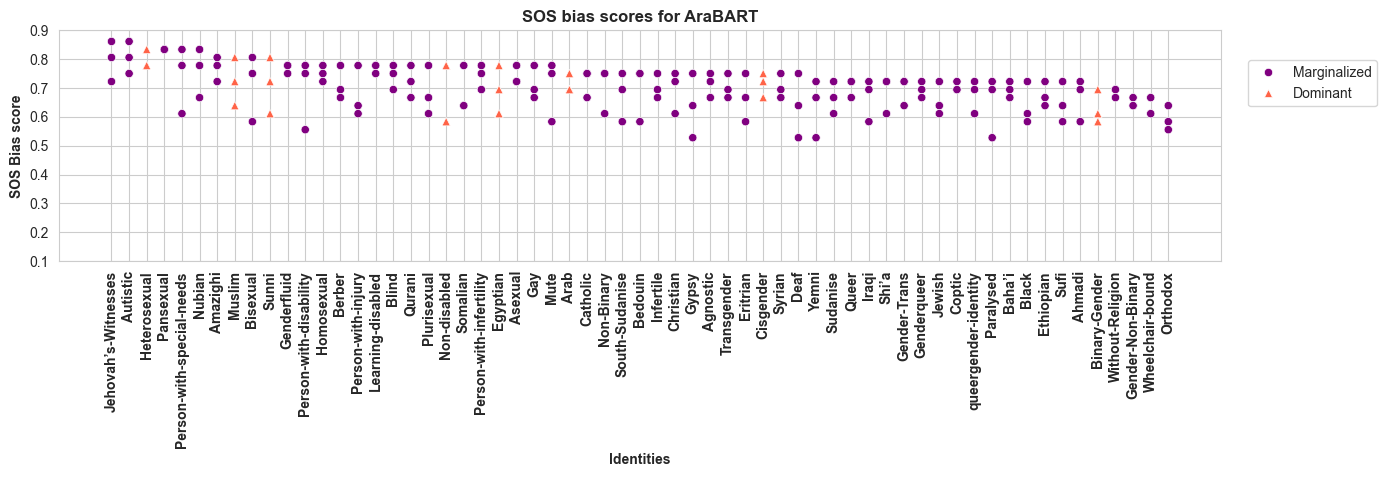

In [8]:
AraBART = display_identity_SOS_scores(AraBART_results_Masc, AraBART_results_Femm, AraBART_results_NB)
#AraBART["identity_in_english"] = [i[0] for i in AraBART.identity_in_english.values]
AraBART = AraBART.sort_values(by="percentage_of_toxic_sentences", ascending=False)

identityies_in_englsih = []
for i, r in AraBART[AraBART.percentage_of_toxic_sentences>0.5].groupby("identity_in_english", sort=False, as_index=False):
    identityies_in_englsih.append(r["identity_in_english"].values[0])

palette = {"Dominant":"tomato", "Marginalized":"purple"}
fig1, axs1 = plt.subplots(figsize=(15, 3))
sns.scatterplot(data = AraBART[AraBART.percentage_of_toxic_sentences > 0.5], x='identity_in_english', y='percentage_of_toxic_sentences', hue='group', style="group", ax=axs1, palette=palette, markers={'Dominant':"^", 'Marginalized':"o"})
axs1.set_xticks(range(0, len(identityies_in_englsih)),identityies_in_englsih, rotation = 90, fontweight='bold')
axs1.legend(bbox_to_anchor=(0.94, 0.1, 0.2, 0.8),ncol=1)
axs1.set_ylabel("SOS Bias score", fontweight="bold")
axs1.set_xlabel("Identities", fontweight="bold")
axs1.set_yticks(np.arange(0.1,1,0.1))
axs1.set_title("SOS bias scores for AraBART", fontweight='bold')
fig1.savefig('SOS bias scores for AraBART.png', bbox_inches='tight')

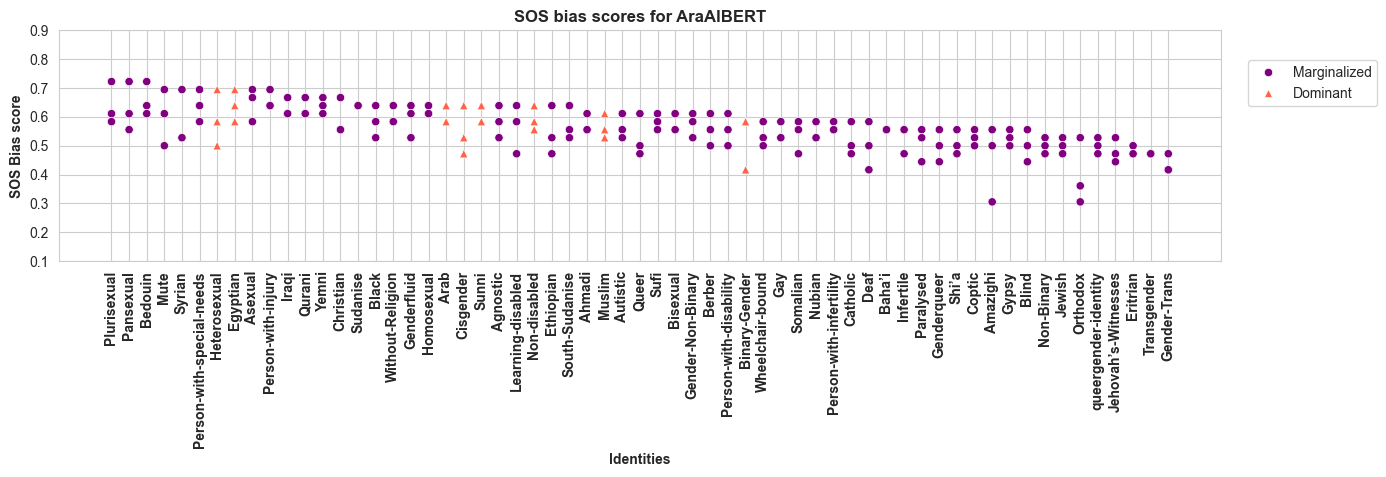

In [9]:
AraAlBERT = display_identity_SOS_scores(AraAlBERT_results_Masc, AraAlBERT_results_Femm, AraAlBERT_results_NB)
AraAlBERT = AraAlBERT.sort_values(by="percentage_of_toxic_sentences", ascending=False)

identityies_in_englsih = []
for i, r in AraAlBERT.groupby("identity_in_english", sort=False, as_index=False):
    identityies_in_englsih.append(r["identity_in_english"].values[0])
    
palette = {"Dominant":"tomato", "Marginalized":"purple"}

fig2, axs2 = plt.subplots(figsize=(15, 3))
sns.scatterplot(data = AraAlBERT, x='identity_in_english', y='percentage_of_toxic_sentences', hue='group', style="group", ax=axs2, palette=palette, markers={'Dominant':"^", 'Marginalized':"o"})
axs2.set_xticks(range(0, len(identityies_in_englsih)),identityies_in_englsih, rotation = 90, fontweight='bold')
axs2.legend(bbox_to_anchor=(0.94, 0.1, 0.2, 0.8),ncol=1)
axs2.set_ylabel("SOS Bias score", fontweight="bold")
axs2.set_xlabel("Identities", fontweight="bold")
axs2.set_yticks(np.arange(0.1,1,0.1))
axs2.set_title("SOS bias scores for AraAlBERT", fontweight='bold')
fig2.savefig('SOS bias scores for AraAlBERT.png', bbox_inches='tight')

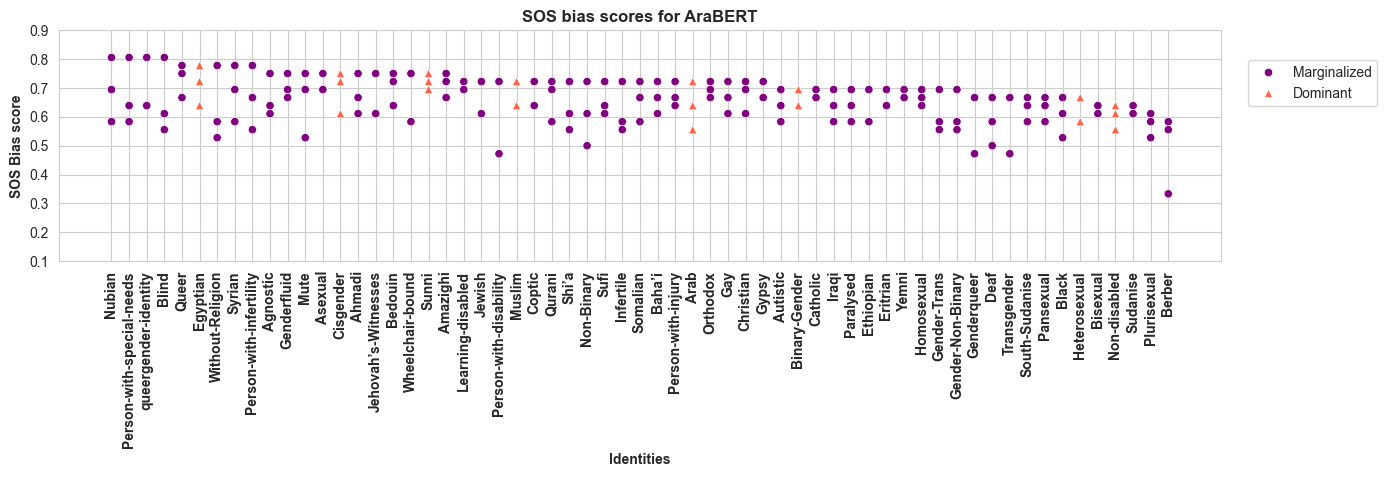

In [10]:
AraBERT = display_identity_SOS_scores(AraBERT_results_Masc, AraBERT_results_Femm, AraBERT_results_NB)
AraBERT = AraBERT.sort_values(by="percentage_of_toxic_sentences", ascending=False)

identityies_in_englsih = []
for i, r in AraBERT.groupby("identity_in_english", sort=False, as_index=False):
    identityies_in_englsih.append(r["identity_in_english"].values[0])

palette = {"Dominant":"tomato", "Marginalized":"purple"}

fig3, axs3 = plt.subplots(figsize=(15, 3))
sns.scatterplot(data = AraBERT, x='identity_in_english', y='percentage_of_toxic_sentences', hue='group', style="group", ax=axs3, palette=palette, markers={'Dominant':"^", 'Marginalized':"o"})
axs3.set_xticks(range(0, len(identityies_in_englsih)),identityies_in_englsih, rotation = 90, fontweight='bold')
axs3.legend(bbox_to_anchor=(0.94, 0.1, 0.2, 0.8),ncol=1)
axs3.set_ylabel("SOS Bias score", fontweight="bold")
axs3.set_xlabel("Identities", fontweight="bold")
axs3.set_yticks(np.arange(0.1,1,0.1))
axs3.set_title("SOS bias scores for AraBERT", fontweight='bold')
fig3.savefig('SOS bias scores for AraBERT.png', bbox_inches='tight')

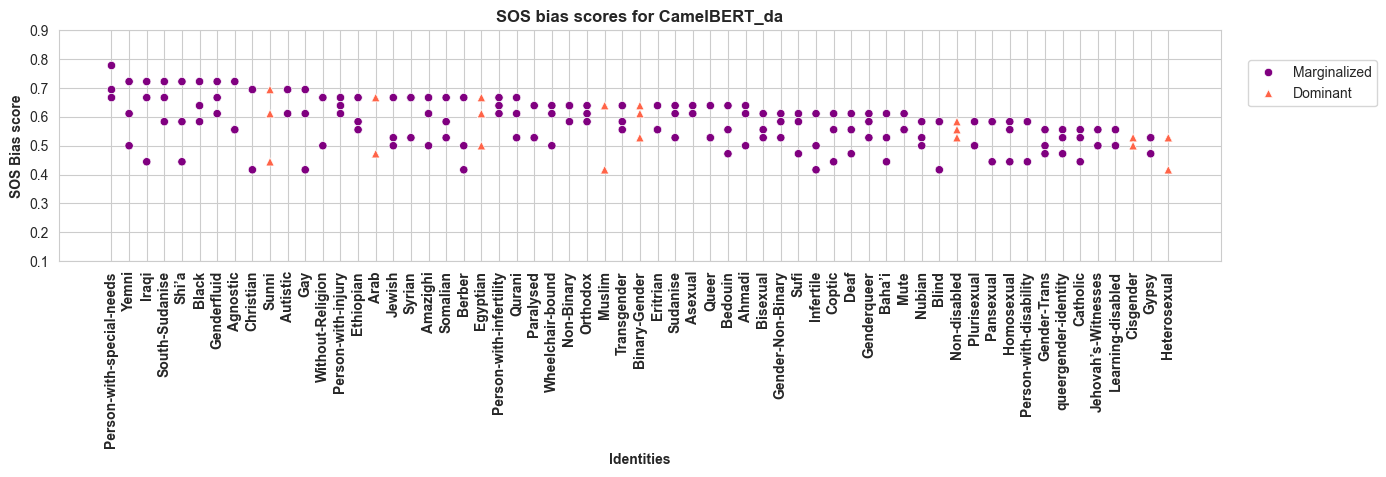

In [62]:
CamelBERT_da = display_identity_SOS_scores(CamelBERT_da_results_Masc, CamelBERT_da_results_Femm, CamelBERT_da_results_NB)
CamelBERT_da = CamelBERT_da.sort_values(by="percentage_of_toxic_sentences", ascending=False)

identityies_in_englsih = []
for i, r in CamelBERT_da.groupby("identity_in_english", sort=False, as_index=False):
    identityies_in_englsih.append(r["identity_in_english"].values[0])

palette = {"Dominant":"tomato", "Marginalized":"purple"}

fig4, axs4 = plt.subplots(figsize=(15, 3))
sns.scatterplot(data = CamelBERT_da, x='identity_in_english', y='percentage_of_toxic_sentences', hue="group", style="group", ax=axs4, palette=palette, markers={'Dominant':"^", 'Marginalized':"o"})
axs4.set_xticks(range(0, len(identityies_in_englsih)),identityies_in_englsih, rotation = 90, fontweight='bold')
axs4.legend(bbox_to_anchor=(0.94, 0.1, 0.2, 0.8),ncol=1)
axs4.set_ylabel("SOS Bias score", fontweight="bold")
axs4.set_xlabel("Identities", fontweight="bold")
axs4.set_yticks(np.arange(0.1,1,0.1))
axs4.set_title("SOS bias scores for CamelBERT_da", fontweight='bold')
fig4.savefig('SOS bias scores for CamelBERT_da.png', bbox_inches='tight')

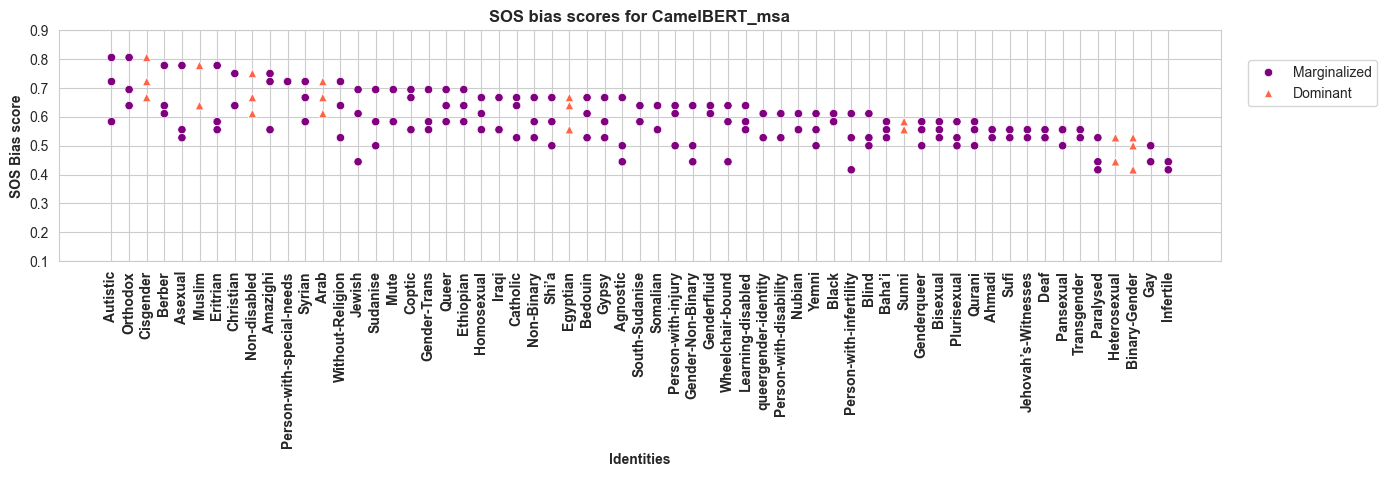

In [63]:
CamelBERT_msa = display_identity_SOS_scores(CamelBERT_msa_results_Masc, CamelBERT_msa_results_Femm, CamelBERT_msa_results_NB)
CamelBERT_msa = CamelBERT_msa.sort_values(by="percentage_of_toxic_sentences", ascending=False)

identityies_in_englsih = []
for i, r in CamelBERT_msa.groupby("identity_in_english", sort=False, as_index=False):
    identityies_in_englsih.append(r["identity_in_english"].values[0])

palette = {"Dominant":"tomato", "Marginalized":"purple"}

fig5, axs5 = plt.subplots(figsize=(15, 3))
sns.scatterplot(data = CamelBERT_msa, x='identity_in_english', y='percentage_of_toxic_sentences', hue='group', style="group", ax=axs5, palette=palette, markers={'Dominant':"^", 'Marginalized':"o"})
axs5.set_xticks(range(0, len(identityies_in_englsih)),identityies_in_englsih, rotation = 90, fontweight='bold')
axs5.legend(bbox_to_anchor=(0.94, 0.1, 0.2, 0.8),ncol=1)
axs5.set_ylabel("SOS Bias score", fontweight="bold")
axs5.set_xlabel("Identities", fontweight="bold")
axs5.set_yticks(np.arange(0.1,1,0.1))
axs5.set_title("SOS bias scores for CamelBERT_msa", fontweight='bold')
fig5.savefig('SOS bias scores for CamelBERT_msa.png', bbox_inches='tight')

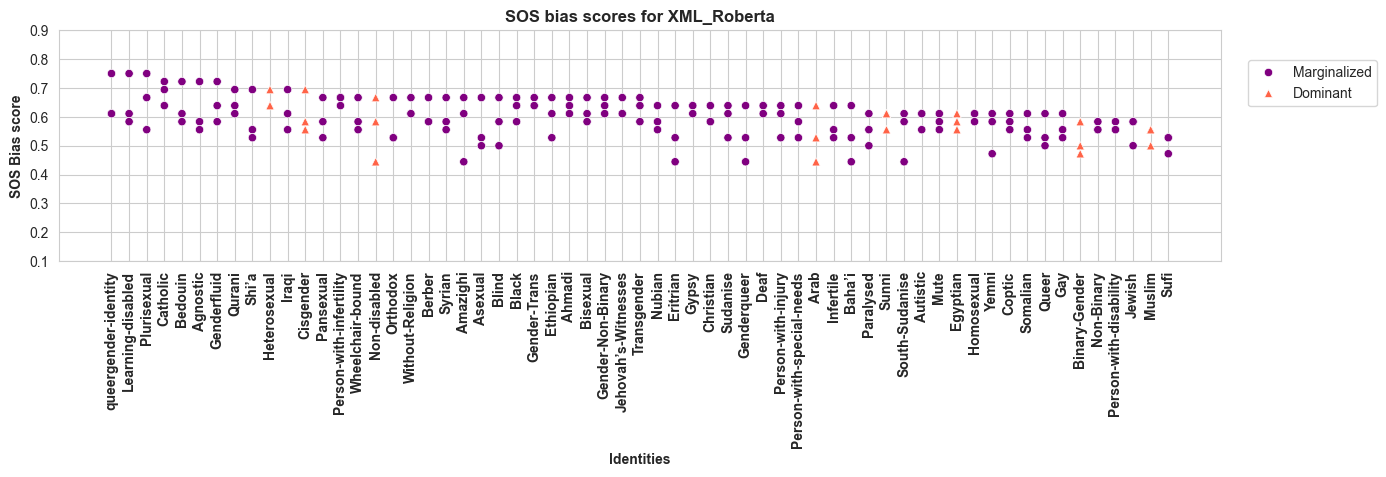

In [11]:
XML_Roberta = display_identity_SOS_scores(XML_Roberta_results_Masc, XML_Roberta_results_Femm, XML_Roberta_results_NB)
XML_Roberta = XML_Roberta.sort_values(by="percentage_of_toxic_sentences", ascending=False)

identityies_in_englsih = []
for i, r in XML_Roberta.groupby("identity_in_english", sort=False, as_index=False):
    identityies_in_englsih.append(r["identity_in_english"].values[0])

palette = {"Dominant":"tomato", "Marginalized":"purple"}

fig6, axs6 = plt.subplots(figsize=(15, 3))
sns.scatterplot(data = XML_Roberta, x='identity_in_english', y='percentage_of_toxic_sentences', hue='group', style="group", ax=axs6, palette=palette, markers={'Dominant':"^", 'Marginalized':"o"})
axs6.set_xticks(range(0, len(identityies_in_englsih)),identityies_in_englsih, rotation = 90, fontweight='bold')
axs6.legend(bbox_to_anchor=(0.94, 0.1, 0.2, 0.8),ncol=1)
axs6.set_ylabel("SOS Bias score", fontweight="bold")
axs6.set_xlabel("Identities", fontweight="bold")
axs6.set_yticks(np.arange(0.1,1,0.1))
axs6.set_title("SOS bias scores for XML_Roberta", fontweight='bold')
fig6.savefig('SOS bias scores for XML_Roberta.png', bbox_inches='tight')

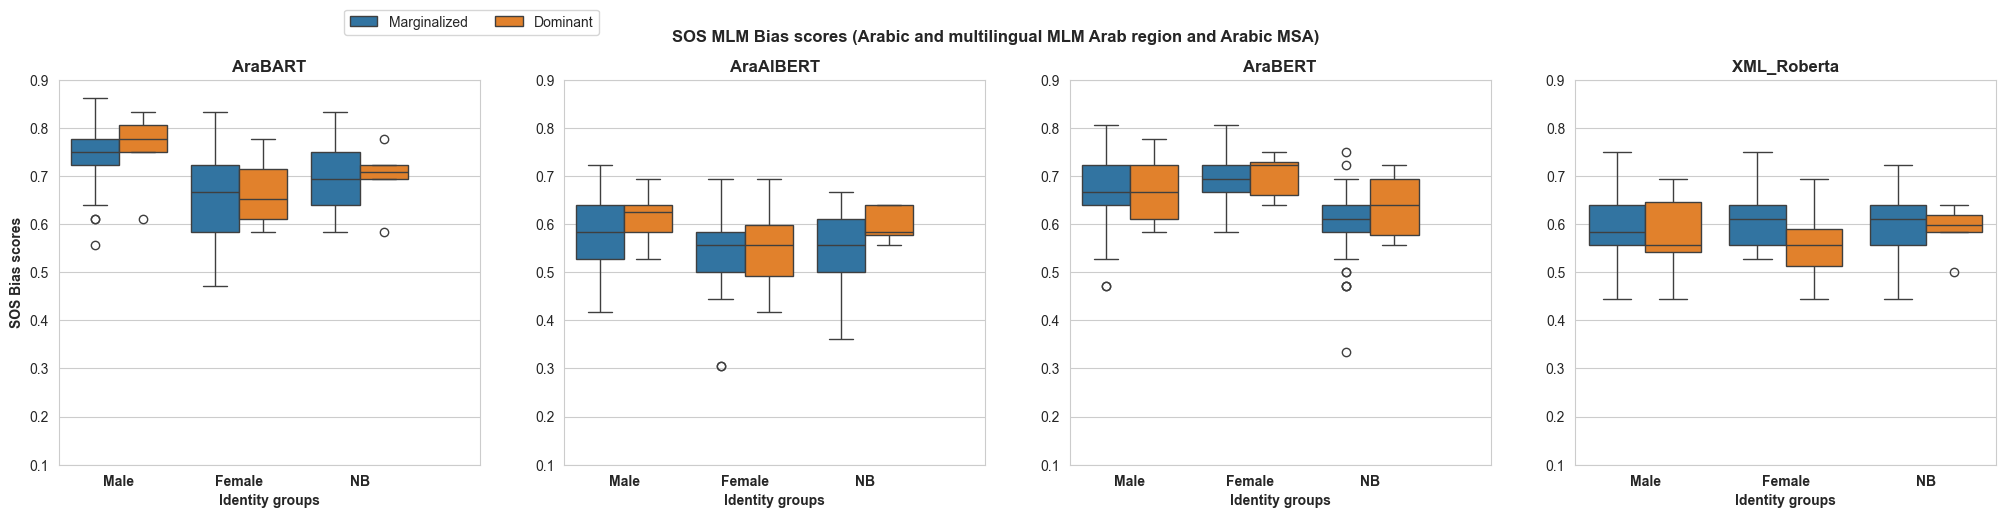

In [65]:
fig, axs = plt.subplots(1,4, figsize=(25, 5))
fig.suptitle("SOS MLM Bias scores (Arabic and multilingual MLM Arab region and Arabic MSA)", fontweight="bold")


sns.boxplot(data=AraBART, y="percentage_of_toxic_sentences", x="gender", hue="group",ax=axs[0])
axs[0].set_title("AraBART", fontweight="bold")
axs[0].legend(bbox_to_anchor=(1.1, 0.4, 0.2, 0.8),ncol=3)
axs[0].set_xticks("")
axs[0].set(xlabel="")
axs[0].set_ylabel("SOS Bias scores", fontweight="bold")
#axs[0].get_legend().remove()
axs[0].set_yticks(np.arange(0.1,1,0.1))
axs[0].set_xticks([0,1,2], ["Male", "Female", "NB"], fontweight="bold")
axs[0].set_yticks(np.arange(0.1,1,0.1))
axs[0].set_xlabel("Identity groups", fontweight="bold")

sns.boxplot(data=AraAlBERT, y="percentage_of_toxic_sentences", x="gender", hue="group",ax=axs[1])
axs[1].set_title("AraAlBERT", fontweight="bold")
#axs[1].legend(bbox_to_anchor=(0.8, 0.7, 0.2, 0.8),ncol=3)
axs[1].set(xlabel="")
axs[1].set(ylabel="")
axs[1].set_xticks("")
axs[1].get_legend().remove()
axs[1].set_yticks(np.arange(0.1,1,0.1))
axs[1].set_xticks([0,1,2], ["Male", "Female", "NB"], fontweight="bold")
axs[1].set_yticks(np.arange(0.1,1,0.1))
axs[1].set_xlabel("Identity groups", fontweight="bold")


sns.boxplot(data=AraBERT, y="percentage_of_toxic_sentences", x="gender", hue="group",ax=axs[2])
axs[2].set_title("AraBERT", fontweight="bold")
#axs[2].legend(bbox_to_anchor=(0.8, 0.5, 0.2, 0.8),ncol=3)
axs[2].set(xlabel="")
axs[2].set(ylabel="")
axs[2].set_xticks("")
axs[2].set_yticks(np.arange(0.1,1,0.1))
axs[2].get_legend().remove()
axs[2].set_xticks([0,1,2], ["Male", "Female", "NB"], fontweight="bold")
axs[2].set_yticks(np.arange(0.1,1,0.1))
axs[2].set_xlabel("Identity groups", fontweight="bold")

sns.boxplot(data=XML_Roberta, y="percentage_of_toxic_sentences", x="gender", hue="group",ax=axs[3])
axs[3].set_title("XML_Roberta", fontweight="bold")
#axs[5].legend(bbox_to_anchor=(0.8, -1.1, 0.2, 0.8),ncol=3)
axs[3].set(ylabel="")
axs[3].set_xticks([0,1,2], ["Male", "Female", "NB"], fontweight="bold")
axs[3].set_yticks(np.arange(0.1,1,0.1))
axs[3].set_xlabel("Identity groups", fontweight="bold")
axs[3].get_legend().remove()

fig.savefig('Summarized_SOS_bias_scores_Egypt_boxplot.png', bbox_inches='tight')

In [66]:
print("AraBART", AraBART.percentage_of_toxic_sentences.mean())
print("AraAlBERT", AraAlBERT.percentage_of_toxic_sentences.mean())
print("AraBERT", AraBERT.percentage_of_toxic_sentences.mean())
print("CamelBERT_da", CamelBERT_da.percentage_of_toxic_sentences.mean())
print("CamelBERT_msa", CamelBERT_msa.percentage_of_toxic_sentences.mean())
print("XML_Roberta", XML_Roberta.percentage_of_toxic_sentences.mean())

AraBART 0.7006678809957497
AraAlBERT 0.5608682452944748
AraBERT 0.6545233758348512
CamelBERT_da 0.5760473588342439
CamelBERT_msa 0.592289010321797
XML_Roberta 0.5957802064359441


In [67]:
AraBART.bias_type.unique()

array(['Religion_Marginalized', 'Physical_ability_Marginalized',
       'Sexual_orientation_Non_Marginalized',
       'Sexual_orientation_Marginalized', 'Race_Marginalized',
       'Religion_Non_Marginalized', 'Gender_Marginalized',
       'Physical_ability_Non_Marginalized', 'Refugees_Marginalized',
       'Refugees_Non_Marginalized', 'Race_Non_marginalized',
       'Gender_Non_marginalized'], dtype=object)

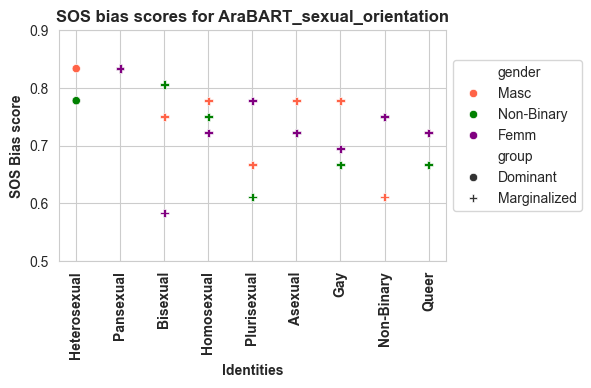

In [68]:
AraBART = display_identity_SOS_scores(AraBART_results_Masc, AraBART_results_Femm, AraBART_results_NB)
AraBART = AraBART.sort_values(by="percentage_of_toxic_sentences", ascending=False)

AraBART_sexual_orientation = AraBART[AraBART["bias_type"].isin(["Sexual_orientation_Marginalized",
                                                       "Sexual_orientation_Non_Marginalized"])]

AraBART_sexual_orientation = AraBART_sexual_orientation.sort_values(by="percentage_of_toxic_sentences", ascending=False)

identityies_in_englsih = []
for i, r in AraBART_sexual_orientation.groupby("identity_in_english", sort=False, as_index=False):
    identityies_in_englsih.append(r["identity_in_english"].values[0])

palette = {"Masc":"tomato", "Femm":"purple", "Non-Binary":"green"}

fig3, axs3 = plt.subplots(figsize=(5, 3))
sns.scatterplot(data = AraBART_sexual_orientation, x='identity_in_english', y='percentage_of_toxic_sentences', hue='gender', style="group", ax=axs3, palette=palette, markers={'Dominant':"o", 'Marginalized':"P"})
axs3.set_xticks(range(0, len(identityies_in_englsih)),identityies_in_englsih, rotation = 90, fontweight='bold')
axs3.legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
axs3.set_ylabel("SOS Bias score", fontweight="bold")
axs3.set_xlabel("Identities", fontweight="bold")
axs3.set_yticks(np.arange(0.5,1,0.1))
axs3.set_title("SOS bias scores for AraBART_sexual_orientation", fontweight='bold')
fig3.savefig('SOS bias scores for AraBART_sexual_orientation (Egypt).png', bbox_inches='tight')

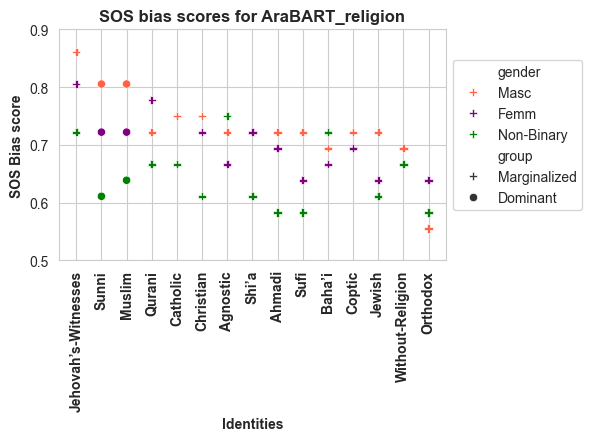

In [69]:
AraBART = display_identity_SOS_scores(AraBART_results_Masc, AraBART_results_Femm, AraBART_results_NB)
AraBART = AraBART.sort_values(by="percentage_of_toxic_sentences", ascending=False)

AraBART_religion = AraBART[AraBART["bias_type"].isin(["Religion_Marginalized",
                                                       "Religion_Non_Marginalized"])]

AraBART_religion = AraBART_religion.sort_values(by="percentage_of_toxic_sentences", ascending=False)

identityies_in_englsih = []
for i, r in AraBART_religion.groupby("identity_in_english", sort=False, as_index=False):
    identityies_in_englsih.append(r["identity_in_english"].values[0])

palette = {"Masc":"tomato", "Femm":"purple", "Non-Binary":"green"}

fig3, axs3 = plt.subplots(figsize=(5, 3))
sns.scatterplot(data = AraBART_religion, x='identity_in_english', y='percentage_of_toxic_sentences', hue='gender', style="group", ax=axs3, palette=palette, markers={'Dominant':"o", 'Marginalized':"P"})
axs3.set_xticks(range(0, len(identityies_in_englsih)),identityies_in_englsih, rotation = 90, fontweight='bold')
axs3.legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
axs3.set_ylabel("SOS Bias score", fontweight="bold")
axs3.set_xlabel("Identities", fontweight="bold")
axs3.set_yticks(np.arange(0.5,1,0.1))
axs3.set_title("SOS bias scores for AraBART_religion", fontweight='bold')
fig3.savefig('SOS bias scores for AraBART_religion (Egypt).png', bbox_inches='tight')

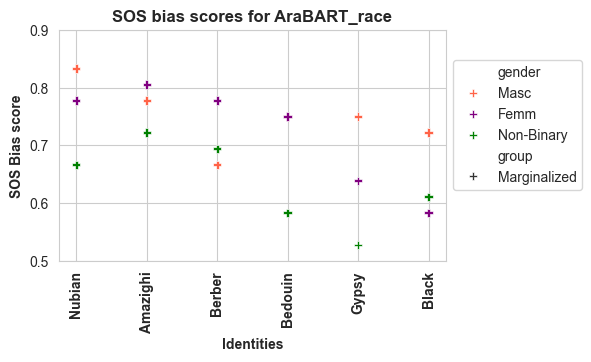

In [70]:
AraBART = display_identity_SOS_scores(AraBART_results_Masc, AraBART_results_Femm, AraBART_results_NB)
AraBART = AraBART.sort_values(by="percentage_of_toxic_sentences", ascending=False)

AraBART_race = AraBART[AraBART["bias_type"].isin(["Race_Marginalized",
                                                       "Race_None_Marginalized"])]

AraBART_race = AraBART_race.sort_values(by="percentage_of_toxic_sentences", ascending=False)

identityies_in_englsih = []
for i, r in AraBART_race.groupby("identity_in_english", sort=False, as_index=False):
    identityies_in_englsih.append(r["identity_in_english"].values[0])

palette = {"Masc":"tomato", "Femm":"purple", "Non-Binary":"green"}

fig3, axs3 = plt.subplots(figsize=(5, 3))
sns.scatterplot(data = AraBART_race, x='identity_in_english', y='percentage_of_toxic_sentences', hue='gender', style="group", ax=axs3, palette=palette, markers={'Dominant':"o", 'Marginalized':"P"})
axs3.set_xticks(range(0, len(identityies_in_englsih)),identityies_in_englsih, rotation = 90, fontweight='bold')
axs3.legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
axs3.set_ylabel("SOS Bias score", fontweight="bold")
axs3.set_xlabel("Identities", fontweight="bold")
axs3.set_yticks(np.arange(0.5,1,0.1))
axs3.set_title("SOS bias scores for AraBART_race", fontweight='bold')
fig3.savefig('SOS bias scores for AraBART_race (Egypt).png', bbox_inches='tight')

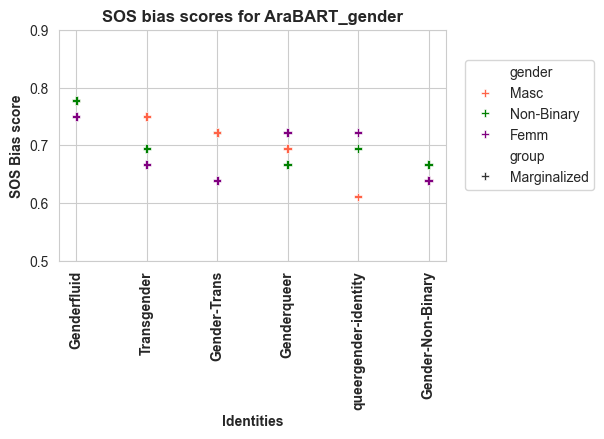

In [71]:
AraBART = display_identity_SOS_scores(AraBART_results_Masc, AraBART_results_Femm, AraBART_results_NB)
AraBART = AraBART.sort_values(by="percentage_of_toxic_sentences", ascending=False)

AraBART_gender = AraBART[AraBART["bias_type"].isin(["Gender_Marginalized",
                                                       "Gender_None_Marginalized"])]

AraBERT_gender = AraBART_gender.sort_values(by="percentage_of_toxic_sentences", ascending=False)

identityies_in_englsih = []
for i, r in AraBART_gender.groupby("identity_in_english", sort=False, as_index=False):
    identityies_in_englsih.append(r["identity_in_english"].values[0])

palette = {"Masc":"tomato", "Femm":"purple", "Non-Binary":"green"}

fig3, axs3 = plt.subplots(figsize=(5, 3))
sns.scatterplot(data = AraBART_gender, x='identity_in_english', y='percentage_of_toxic_sentences', hue='gender', style="group", ax=axs3, palette=palette, markers={'Dominant':"o", 'Marginalized':"P"})
axs3.set_xticks(range(0, len(identityies_in_englsih)),identityies_in_englsih, rotation = 90, fontweight='bold')
axs3.legend(bbox_to_anchor=(1.2, 0.1, 0.2, 0.8),ncol=1)
axs3.set_ylabel("SOS Bias score", fontweight="bold")
axs3.set_xlabel("Identities", fontweight="bold")
axs3.set_yticks(np.arange(0.5,1,0.1))
axs3.set_title("SOS bias scores for AraBART_gender", fontweight='bold')
fig3.savefig('SOS bias scores for AraBART_gender (Egypt).png', bbox_inches='tight')

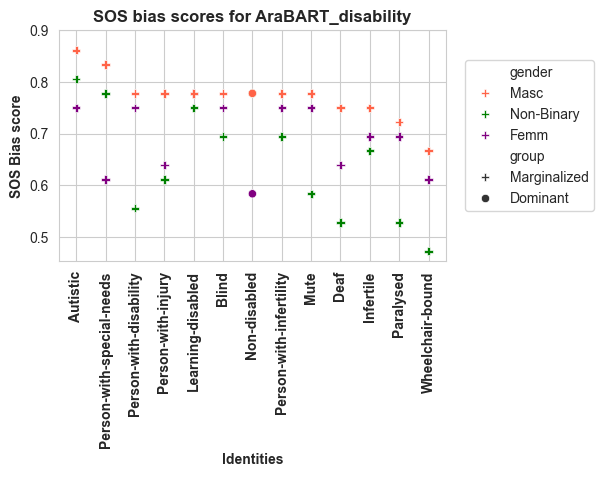

In [72]:
AraBART = display_identity_SOS_scores(AraBART_results_Masc, AraBART_results_Femm, AraBART_results_NB)
AraBART = AraBART.sort_values(by="percentage_of_toxic_sentences", ascending=False)

AraBART_disability = AraBART[AraBART["bias_type"].isin(["Physical_ability_Marginalized",
                                                       "Physical_ability_Non_Marginalized"])]

AraBART_disability = AraBART_disability.sort_values(by="percentage_of_toxic_sentences", ascending=False)

identityies_in_englsih = []
for i, r in AraBART_disability.groupby("identity_in_english", sort=False, as_index=False):
    identityies_in_englsih.append(r["identity_in_english"].values[0])

palette = {"Masc":"tomato", "Femm":"purple", "Non-Binary":"green"}

fig3, axs3 = plt.subplots(figsize=(5, 3))
sns.scatterplot(data = AraBART_disability, x='identity_in_english', y='percentage_of_toxic_sentences', hue='gender', style="group", ax=axs3, palette=palette, markers={'Dominant':"o", 'Marginalized':"P"})
axs3.set_xticks(range(0, len(identityies_in_englsih)),identityies_in_englsih, rotation = 90, fontweight='bold')
axs3.legend(bbox_to_anchor=(1.2, 0.1, 0.2, 0.8),ncol=1)
axs3.set_ylabel("SOS Bias score", fontweight="bold")
axs3.set_xlabel("Identities", fontweight="bold")
axs3.set_yticks(np.arange(0.5,1,0.1))
axs3.set_title("SOS bias scores for AraBART_disability", fontweight='bold')
fig3.savefig('SOS bias scores for AraBART_disability (Egypt).png', bbox_inches='tight')

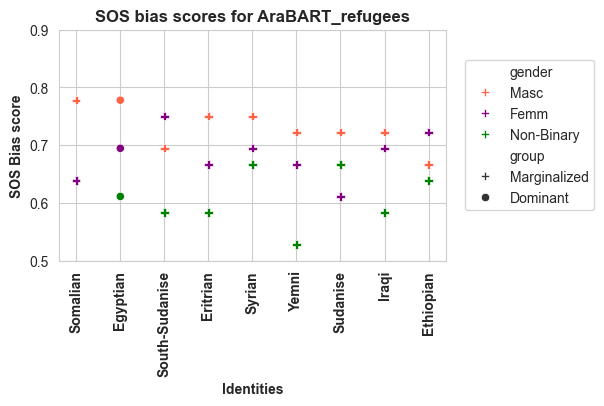

In [73]:
AraBART = display_identity_SOS_scores(AraBART_results_Masc, AraBART_results_Femm, AraBART_results_NB)
AraBART = AraBART.sort_values(by="percentage_of_toxic_sentences", ascending=False)

AraBART_refugees = AraBART[AraBART["bias_type"].isin(["Refugees_Marginalized",
                                                       "Refugees_Non_Marginalized"])]

AraBART_refugees = AraBART_refugees.sort_values(by="percentage_of_toxic_sentences", ascending=False)

identityies_in_englsih = []
for i, r in AraBART_refugees.groupby("identity_in_english", sort=False, as_index=False):
    identityies_in_englsih.append(r["identity_in_english"].values[0])

palette = {"Masc":"tomato", "Femm":"purple", "Non-Binary":"green"}

fig3, axs3 = plt.subplots(figsize=(5, 3))
sns.scatterplot(data = AraBART_refugees, x='identity_in_english', y='percentage_of_toxic_sentences', hue='gender', style="group", ax=axs3, palette=palette, markers={'Dominant':"o", 'Marginalized':"P"})
axs3.set_xticks(range(0, len(identityies_in_englsih)),identityies_in_englsih, rotation = 90, fontweight='bold')
axs3.legend(bbox_to_anchor=(1.2, 0.1, 0.2, 0.8),ncol=1)
axs3.set_ylabel("SOS Bias score", fontweight="bold")
axs3.set_xlabel("Identities", fontweight="bold")
axs3.set_yticks(np.arange(0.5,1,0.1))
axs3.set_title("SOS bias scores for AraBART_refugees", fontweight='bold')
fig3.savefig('SOS bias scores for AraBART_refugees (Egypt).png', bbox_inches='tight')

In [12]:
def plot_sos_bias_for_each_senstive_attribute(model_results_Masc, model_results_Femm, model_results_NB, model_name):
    fig, axs = plt.subplots(3,2, figsize=(10,15))
    
    palette = {"Dominant":"tomato", "Marginalized":"purple"}
    #fig.suptitle("SOS AraAlBERT Bias scores (Arabic and multilingual AraAlBERT Egypt and Egyptian Arabic)", fontweight="bold")
    
    model = display_identity_SOS_scores(model_results_Masc, model_results_Femm, model_results_NB)
    
    model_sexual_orientation = model[model["bias_type"].isin(["Sexual_orientation_Marginalized","Sexual_orientation_Non_Marginalized"])]
    model_sexual_orientation = model_sexual_orientation.sort_values(by="percentage_of_toxic_sentences", ascending=False)
    
    identityies_in_englsih1 = []
    for i, r in model_sexual_orientation.groupby("identity_in_english", sort=False, as_index=False):
        identityies_in_englsih1.append(r["identity_in_english"].values[0])
    
    #palette = {"Masc":"tomato", "Femm":"purple", "Non-Binary":"green"}
    
    sns.scatterplot(data = model_sexual_orientation, x='identity_in_english', y='percentage_of_toxic_sentences', style="group", hue="group", ax=axs[0,0], palette=palette, markers={'Dominant':"^", 'Marginalized':"o"})
    axs[0,0].set_xticks(range(0, len(identityies_in_englsih1)),identityies_in_englsih1, rotation = 90, fontweight='bold')
    axs[0,0].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
    axs[0,0].set_ylabel("SOS Bias score", fontweight="bold")
    axs[0,0].set_xlabel("Identities", fontweight="bold")
    axs[0,0].set_yticks(np.arange(0.1,1,0.1))
    axs[0,0].get_legend().remove()
    axs[0,0].set_title("SOS bias scores for "+model_name+"_sexual_orientation", fontweight='bold')
    #fig1.savefig('SOS bias scores for AraAlBERT_sexual_orientation (Egypt).png', bbox_inches='tight')
    
    model_religion = model[model["bias_type"].isin(["Religion_Marginalized",
                                                           "Religion_Non_Marginalized"])]
    model_religion = model_religion.sort_values(by="percentage_of_toxic_sentences", ascending=False)
    
    identityies_in_englsih2 = []
    for i, r in model_religion.groupby("identity_in_english", sort=False, as_index=False):
        identityies_in_englsih2.append(r["identity_in_english"].values[0])
    

    
    sns.scatterplot(data = model_religion, x='identity_in_english', y='percentage_of_toxic_sentences', style="group", hue="group", ax=axs[0,1], palette=palette, markers={'Dominant':"^", 'Marginalized':"o"})
    axs[0,1].set_xticks(range(0, len(identityies_in_englsih2)),identityies_in_englsih2, rotation = 90, fontweight='bold')
    axs[0,1].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
    axs[0,1].set_ylabel("SOS Bias score", fontweight="bold")
    axs[0,1].set_xlabel("Identities", fontweight="bold")
    axs[0,1].set_yticks(np.arange(0.1,1,0.1))
    axs[0,1].get_legend().remove()
    axs[0,1].set_title("SOS bias scores for "+model_name+"_religion", fontweight='bold')
    #fig2.savefig('SOS bias scores for AraAlBERT_religion (Egypt).png', bbox_inches='tight')
    
    model_race = model[model["bias_type"].isin(["Race_Marginalized",
                                                           "Race_Non_marginalized"])]
    model_race = model_race.sort_values(by="percentage_of_toxic_sentences", ascending=False)
    
    identityies_in_englsih3 = []
    for i, r in model_race.groupby("identity_in_english", sort=False, as_index=False):
        identityies_in_englsih3.append(r["identity_in_english"].values[0])
    
  
    
    sns.scatterplot(data = model_race, x='identity_in_english', y='percentage_of_toxic_sentences', style="group", hue="group", ax=axs[1,0], palette=palette, markers={'Dominant':"^", 'Marginalized':"o"})
    axs[1,0].set_xticks(range(0, len(identityies_in_englsih3)),identityies_in_englsih3, rotation = 90, fontweight='bold')
    axs[1,0].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
    axs[1,0].set_ylabel("SOS Bias score", fontweight="bold")
    axs[1,0].set_xlabel("Identities", fontweight="bold")
    axs[1,0].set_yticks(np.arange(0.1,1,0.1))
    axs[1,0].get_legend().remove()
    axs[1,0].set_title("SOS bias scores for "+model_name+"_race", fontweight='bold')
    #fig3.savefig('SOS bias scores for AraAlBERT_race (Egypt).png', bbox_inches='tight')
    
    
    model_gender = model[model["bias_type"].isin(["Gender_Marginalized",
                                                           "Gender_Non_marginalized"])]
    model_gender = model_gender.sort_values(by="percentage_of_toxic_sentences", ascending=False)
    
    identityies_in_englsih4 = []
    for i, r in model_gender.groupby("identity_in_english", sort=False, as_index=False):
        identityies_in_englsih4.append(r["identity_in_english"].values[0])
    

    
    sns.scatterplot(data = model_gender, x='identity_in_english', y='percentage_of_toxic_sentences', style="group", hue="group",ax=axs[1,1], palette=palette, markers={'Dominant':"^", 'Marginalized':"o"})
    axs[1,1].set_xticks(range(0, len(identityies_in_englsih4)),identityies_in_englsih4, rotation = 90, fontweight='bold')
    axs[1,1].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
    axs[1,1].set_ylabel("SOS Bias score", fontweight="bold")
    axs[1,1].set_xlabel("Identities", fontweight="bold")
    axs[1,1].set_yticks(np.arange(0.1,1,0.1))
    axs[1,1].get_legend().remove()
    axs[1,1].set_title("SOS bias scores for "+model_name+"_gender", fontweight='bold')
    #fig4.savefig('SOS bias scores for AraAlBERT_gender (Egypt).png', bbox_inches='tight')
    
    model_disability = model[model["bias_type"].isin(["Physical_ability_Marginalized",
                                                           "Physical_ability_Non_Marginalized"])]
    
    model_disability = model_disability.sort_values(by="percentage_of_toxic_sentences", ascending=False)
    
    identityies_in_englsih5 = []
    for i, r in model_disability.groupby("identity_in_english", sort=False, as_index=False):
        identityies_in_englsih5.append(r["identity_in_english"].values[0])
    

    
    
    sns.scatterplot(data = model_disability, x='identity_in_english', y='percentage_of_toxic_sentences', style="group", hue= "group",ax=axs[2,0], palette=palette, markers={'Dominant':"^", 'Marginalized':"o"})
    axs[2,0].set_xticks(range(0, len(identityies_in_englsih5)),identityies_in_englsih5, rotation = 90, fontweight='bold')
    axs[2,0].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
    axs[2,0].set_ylabel("SOS Bias score", fontweight="bold")
    axs[2,0].set_xlabel("Identities", fontweight="bold")
    axs[2,0].set_yticks(np.arange(0.1,1,0.1))
    axs[2,0].get_legend().remove()
    axs[2,0].set_title("SOS bias scores for "+model_name+"_disability", fontweight='bold')
    #fig5.savefig('SOS bias scores for AraAlBERT_disability (Egypt).png', bbox_inches='tight')
    
    model_refugees = model[model["bias_type"].isin(["Refugees_Marginalized",
                                                           "Refugees_Non_Marginalized"])]
    
    model_refugees = model_refugees.sort_values(by="percentage_of_toxic_sentences", ascending=False)
    
    identityies_in_englsih6 = []
    for i, r in model_refugees.groupby("identity_in_english", sort=False, as_index=False):
        identityies_in_englsih6.append(r["identity_in_english"].values[0])
    

    
    sns.scatterplot(data = model_refugees, x='identity_in_english', y='percentage_of_toxic_sentences', style="group",hue="group", ax=axs[2,1], palette=palette, markers={'Dominant':"^", 'Marginalized':"o"})
    axs[2,1].set_xticks(range(0, len(identityies_in_englsih6)),identityies_in_englsih6, rotation = 90, fontweight='bold')
    axs[2,1].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
    axs[2,1].set_ylabel("SOS Bias score", fontweight="bold")
    axs[2,1].set_xlabel("Identities", fontweight="bold")
    axs[2,1].set_yticks(np.arange(0.1,1,0.1))
    axs[2,1].set_title("SOS bias scores for "+model_name+"_refugees", fontweight='bold')
    fig.tight_layout()
    fig.savefig('SOS bias scores for '+model_name+ '(Egypt).png', bbox_inches='tight')


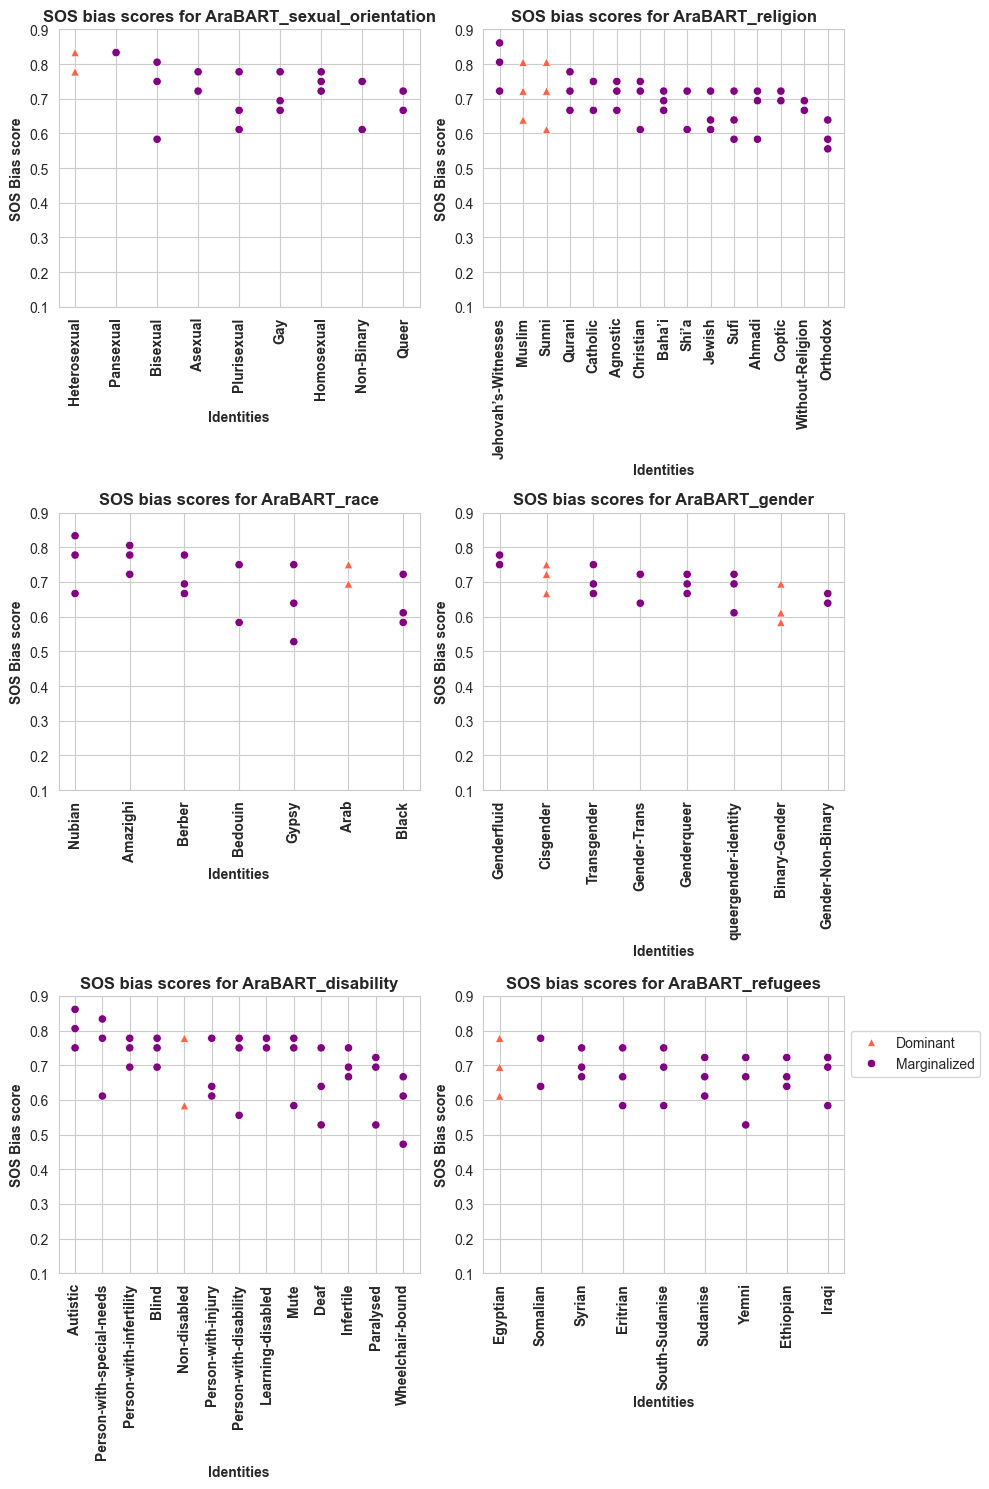

In [13]:
plot_sos_bias_for_each_senstive_attribute(AraBART_results_Masc, AraBART_results_Femm, AraBART_results_NB, "AraBART")

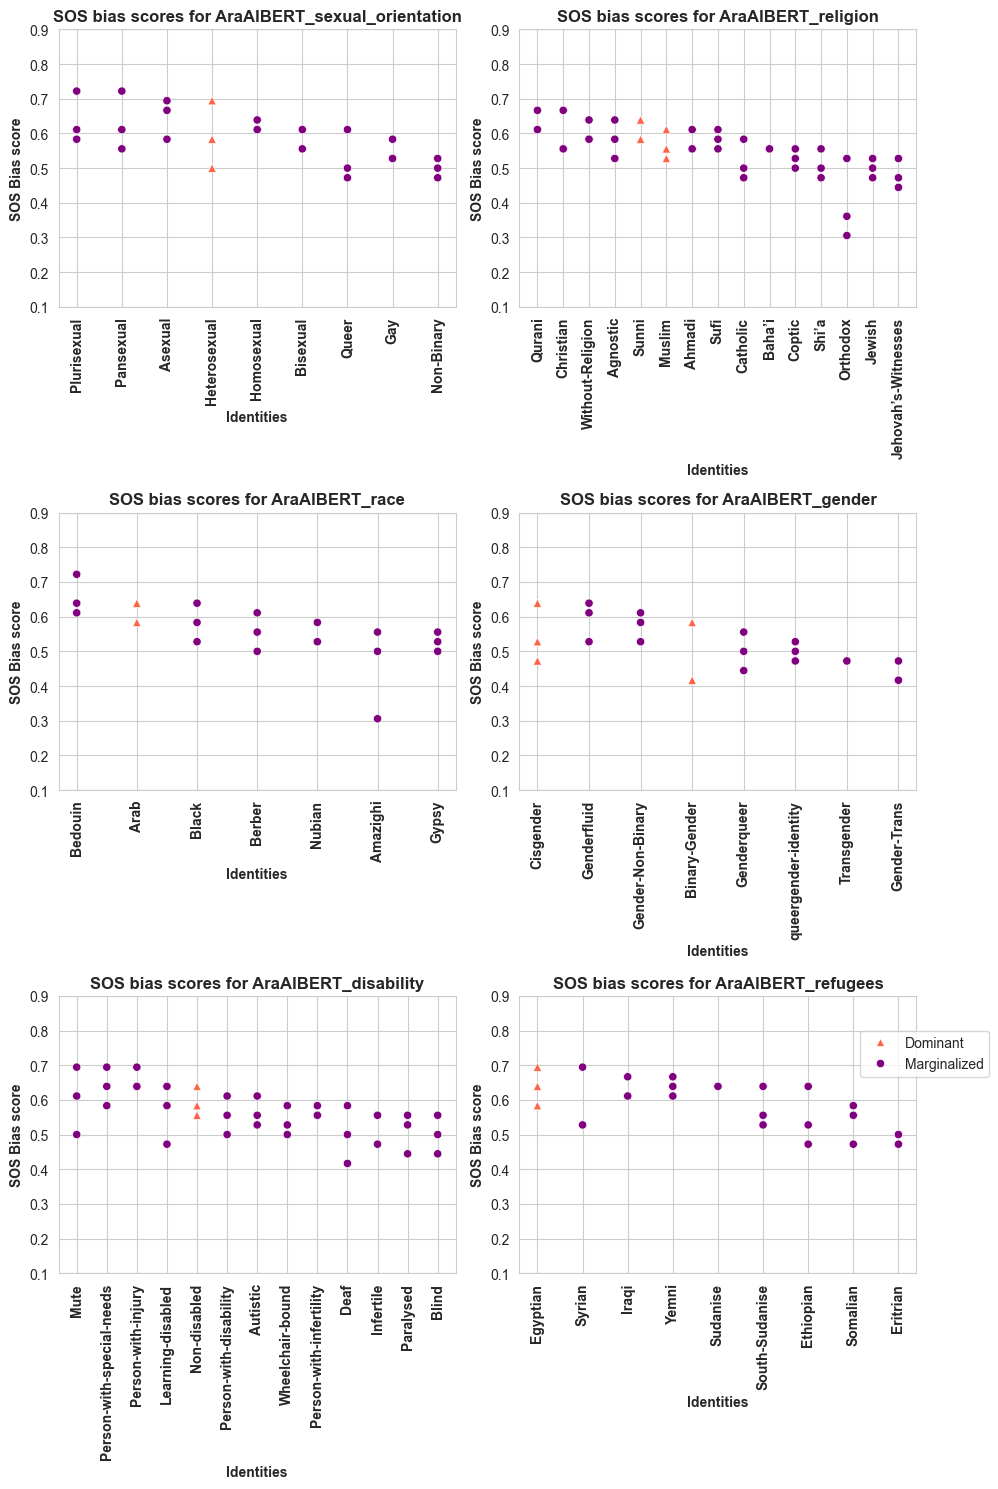

In [14]:
plot_sos_bias_for_each_senstive_attribute(AraAlBERT_results_Masc, AraAlBERT_results_Femm, AraAlBERT_results_NB, "AraAlBERT")

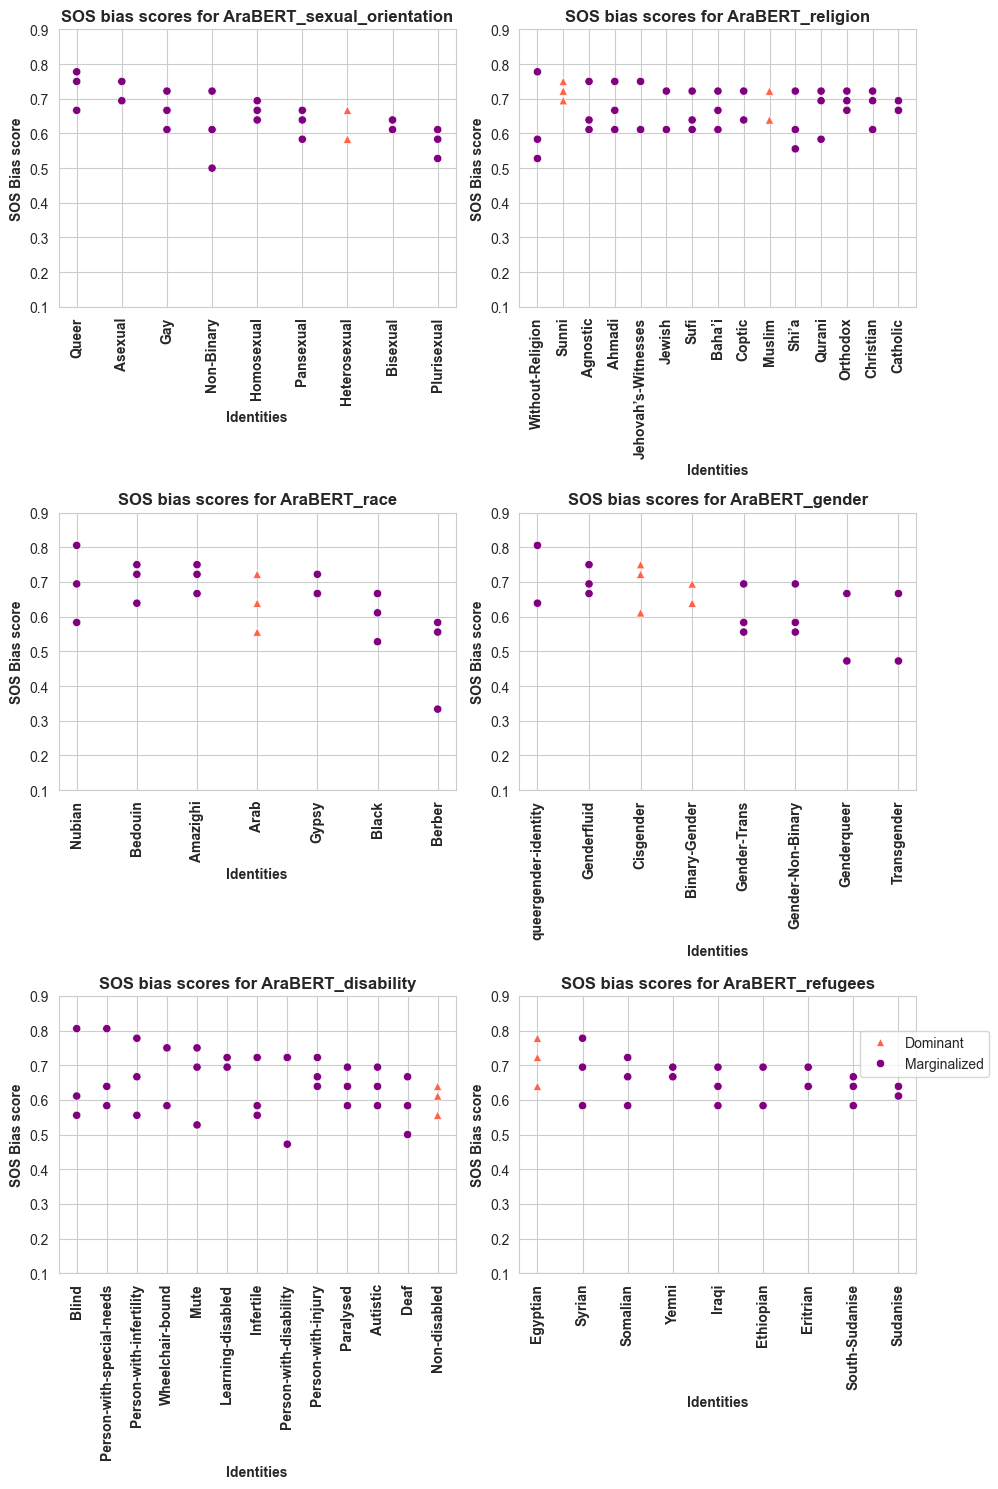

In [15]:
plot_sos_bias_for_each_senstive_attribute(AraBERT_results_Masc, AraBERT_results_Femm, AraBERT_results_NB, "AraBERT")

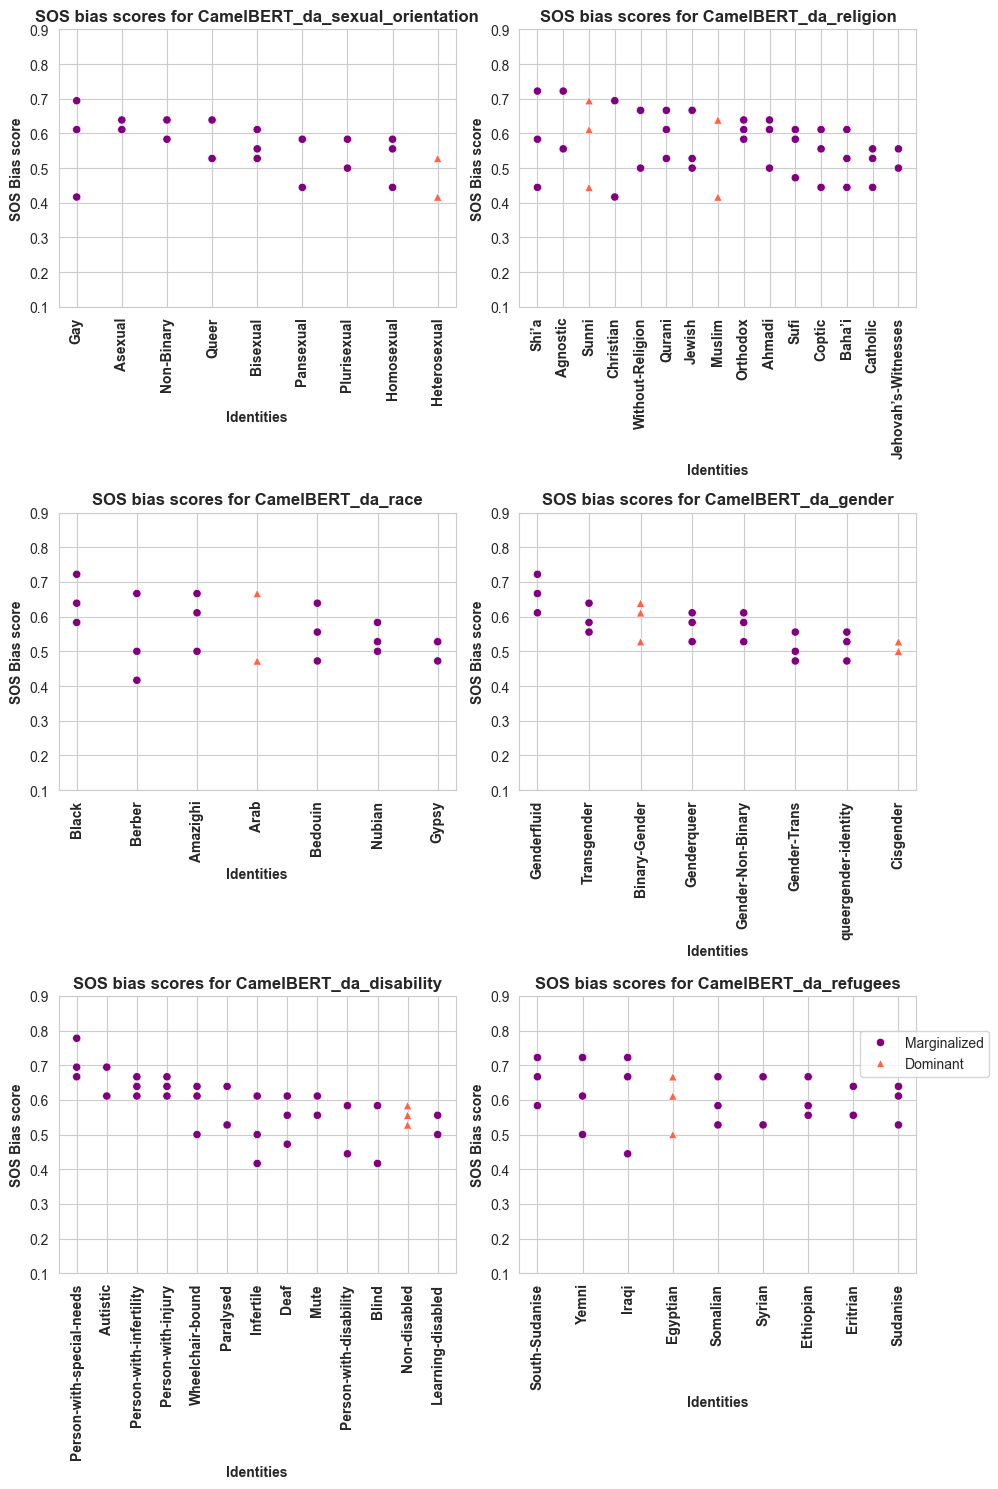

In [78]:
plot_sos_bias_for_each_senstive_attribute(CamelBERT_da_results_Masc, CamelBERT_da_results_Femm, CamelBERT_da_results_NB, "CamelBERT_da")

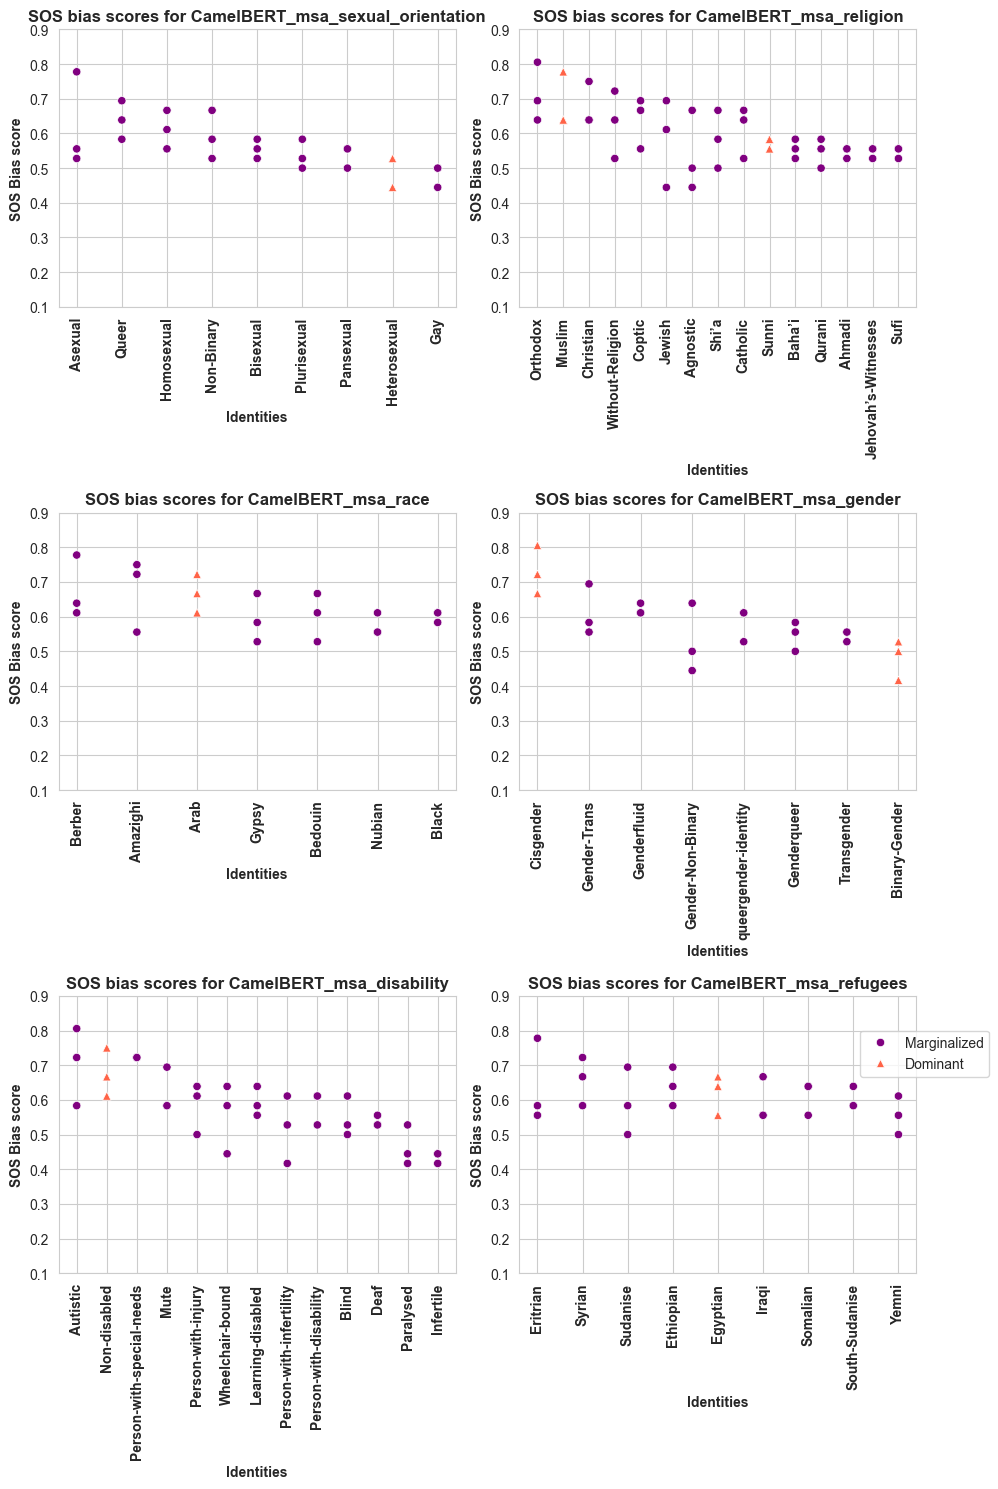

In [79]:
plot_sos_bias_for_each_senstive_attribute(CamelBERT_msa_results_Masc, CamelBERT_msa_results_Femm, CamelBERT_msa_results_NB, "CamelBERT_msa")

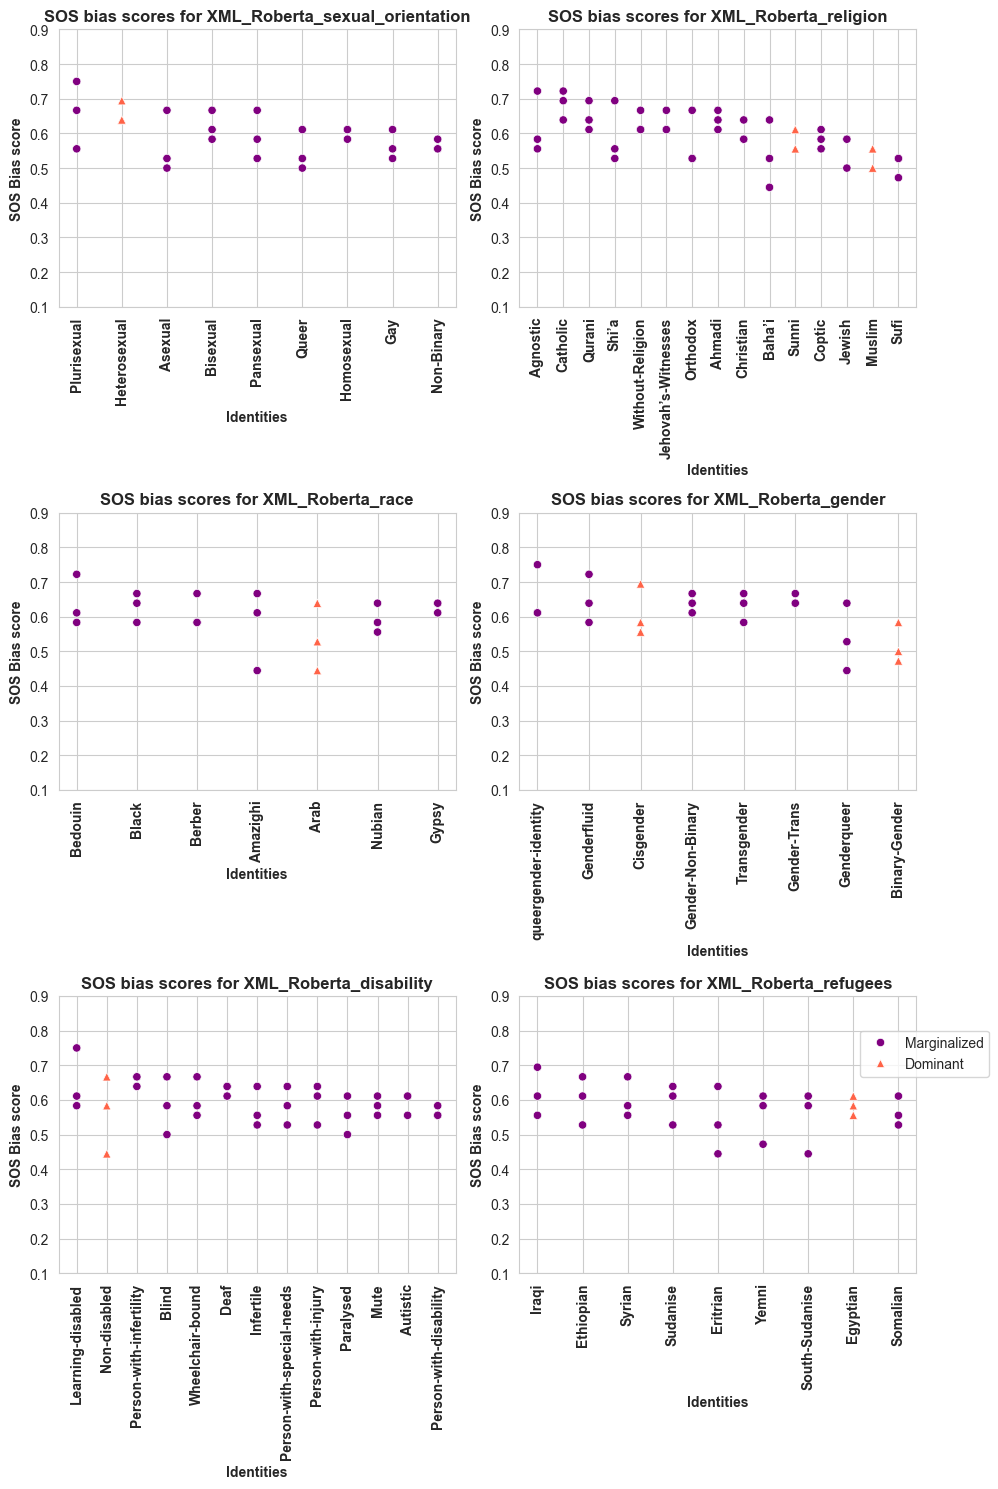

In [80]:
plot_sos_bias_for_each_senstive_attribute(XML_Roberta_results_Masc, XML_Roberta_results_Femm, XML_Roberta_results_NB, "XML_Roberta")

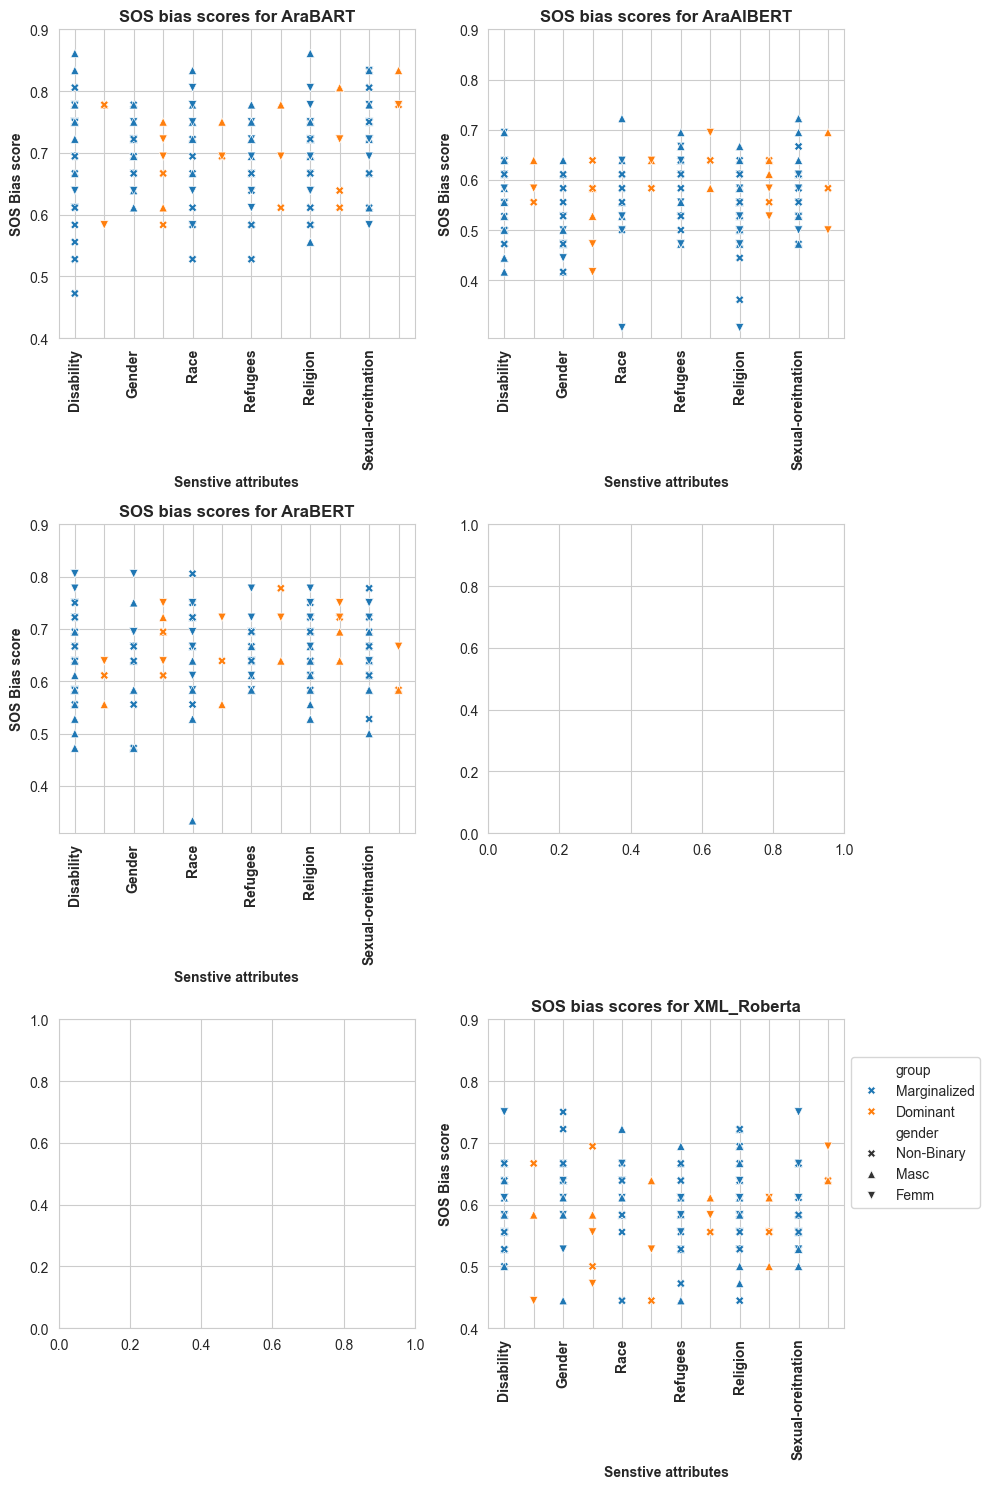

In [18]:
fig, axs = plt.subplots(3,2, figsize=(10,15))

xlabels = ["Disability","", "Gender", '', "Race", "", "Refugees","", "Religion","", "Sexual-oreitnation",""]

AraBART_display = display_identity_SOS_scores(AraBART_results_Masc, AraBART_results_Femm, AraBART_results_NB)
AraBART_display["Model_Name"] = "AraBART"
AraBART_display["sens_attribute"] = AraBART_display["bias_type"].apply(lambda x:match_sens_attr(x))
AraBART_display = AraBART_display.sort_values(by=["sens_attribute"], ascending=[True])
sns.scatterplot(data = AraBART_display, x='sens_attribute', hue='group', y='percentage_of_toxic_sentences', style="gender", ax=axs[0,0],  markers={'Masc':'^', 'Femm':"v", 'Non-Binary':'X'})
axs[0,0].set_xticks(range(0, len(AraBART_display["sens_attribute"].unique())),xlabels, rotation = 90, fontweight='bold')
axs[0,0].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
axs[0,0].set_ylabel("SOS Bias score", fontweight="bold")
axs[0,0].set_xlabel("Senstive attributes", fontweight="bold")
axs[0,0].set_yticks(np.arange(0.4,1,0.1))
axs[0,0].set_title("SOS bias scores for AraBART", fontweight='bold')
axs[0,0].get_legend().remove()
axs[0,0].set_title("SOS bias scores for AraBART", fontweight='bold')
    

AraAlBERT_display = display_identity_SOS_scores(AraAlBERT_results_Masc, AraAlBERT_results_Femm, AraAlBERT_results_NB)
AraAlBERT_display["Model_Name"] = "AraAlBERT"
AraAlBERT_display["sens_attribute"] = AraAlBERT_display["bias_type"].apply(lambda x:match_sens_attr(x))
AraAlBERT_display = AraAlBERT_display.sort_values(by=["sens_attribute"], ascending=[True])
sns.scatterplot(data = AraAlBERT_display, x='sens_attribute', hue='group', y='percentage_of_toxic_sentences', style="gender", ax=axs[0,1],  markers={'Masc':'^', 'Femm':"v", 'Non-Binary':'X'})
axs[0,1].set_xticks(range(0, len(AraAlBERT_display["sens_attribute"].unique())),xlabels, rotation = 90, fontweight='bold')
axs[0,1].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
axs[0,1].set_ylabel("SOS Bias score", fontweight="bold")
axs[0,1].set_xlabel("Senstive attributes", fontweight="bold")
axs[0,1].set_yticks(np.arange(0.4,1,0.1))
axs[0,1].set_title("SOS bias scores for AraAlBERT", fontweight='bold')
axs[0,1].get_legend().remove()
axs[0,1].set_title("SOS bias scores for AraAlBERT", fontweight='bold')

  
AraBERT_display = display_identity_SOS_scores(AraBERT_results_Masc, AraBERT_results_Femm, AraBERT_results_NB)
AraBERT_display["Model_Name"] = "AraBERT"
AraBERT_display["sens_attribute"] = AraBERT_display["bias_type"].apply(lambda x:match_sens_attr(x))
AraBERT_display = AraBERT_display.sort_values(by=["sens_attribute"], ascending=[True])
sns.scatterplot(data = AraBERT_display, x='sens_attribute', hue='group', y='percentage_of_toxic_sentences', style="gender", ax=axs[1,0],  markers={'Masc':'^', 'Femm':"v", 'Non-Binary':'X'})
axs[1,0].set_xticks(range(0, len(AraBERT_display["sens_attribute"].unique())),xlabels, rotation = 90, fontweight='bold')
axs[1,0].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
axs[1,0].set_ylabel("SOS Bias score", fontweight="bold")
axs[1,0].set_xlabel("Senstive attributes", fontweight="bold")
axs[1,0].set_yticks(np.arange(0.4,1,0.1))
axs[1,0].set_title("SOS bias scores for AraBERT", fontweight='bold')
axs[1,0].get_legend().remove()
axs[1,0].set_title("SOS bias scores for AraBERT", fontweight='bold')
    

#CamelBERT_da_display = display_identity_SOS_scores(CamelBERT_da_results_Masc, CamelBERT_da_results_Femm, CamelBERT_da_results_NB)
#CamelBERT_da_display["Model_Name"] = "CamelBERT_da"
#amelBERT_da_display["sens_attribute"] = CamelBERT_da_display["bias_type"].apply(lambda x:match_sens_attr(x))
#CamelBERT_da_display = CamelBERT_da_display.sort_values(by=["sens_attribute"], ascending=[True])
#sns.scatterplot(data = CamelBERT_da_display, x='sens_attribute', hue='group', y='percentage_of_toxic_sentences', style="gender", ax=axs[1,1],  markers={'Masc':'^', 'Femm':"v", 'Non-Binary':'X'})
#axs[1,1].set_xticks(range(0, len(CamelBERT_da_display["sens_attribute"].unique())),xlabels, rotation = 90, fontweight='bold')
#axs[1,1].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
#axs[1,1].set_ylabel("SOS Bias score", fontweight="bold")
#axs[1,1].set_xlabel("Senstive attributes", fontweight="bold")
#axs[1,1].set_yticks(np.arange(0.4,1,0.1))
#axs[1,1].set_title("SOS bias scores for CamelBERT_da", fontweight='bold')
#axs[1,1].get_legend().remove()
#axs[1,1].set_title("SOS bias scores for CamelBERT_da", fontweight='bold')   


#CamelBERT_msa_display = display_identity_SOS_scores(CamelBERT_msa_results_Masc, CamelBERT_msa_results_Femm, CamelBERT_msa_results_NB)
#CamelBERT_msa_display["Model_Name"] = "CamelBERT_msa"
#CamelBERT_msa_display["sens_attribute"] = CamelBERT_msa_display["bias_type"].apply(lambda x:match_sens_attr(x))
#CamelBERT_msa_display = CamelBERT_msa_display.sort_values(by=["sens_attribute"], ascending=[True])
#sns.scatterplot(data = CamelBERT_msa_display, x='sens_attribute', hue='group', y='percentage_of_toxic_sentences', style="gender", ax=axs[2,0],  markers={'Masc':'^', 'Femm':"v", 'Non-Binary':'X'})
#axs[2,0].set_xticks(range(0, len(CamelBERT_msa_display["sens_attribute"].unique())),xlabels, rotation = 90, fontweight='bold')
#axs[2,0].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
#axs[2,0].set_ylabel("SOS Bias score", fontweight="bold")
#axs[2,0].set_xlabel("Senstive attributes", fontweight="bold")
#axs[2,0].set_yticks(np.arange(0.4,1,0.1))
#axs[2,0].set_title("SOS bias scores for CamelBERT_msa", fontweight='bold')
#axs[2,0].get_legend().remove()
#axs[2,0].set_title("SOS bias scores for CamelBERT_msa", fontweight='bold')  


XML_Roberta_display = display_identity_SOS_scores(XML_Roberta_results_Masc, XML_Roberta_results_Femm, XML_Roberta_results_NB)
XML_Roberta_display["Model_Name"] = "XLM_Roberta"
XML_Roberta_display["sens_attribute"] = XML_Roberta_display["bias_type"].apply(lambda x:match_sens_attr(x))
XML_Roberta_display = XML_Roberta_display.sort_values(by=["sens_attribute"], ascending=[True])
sns.scatterplot(data = XML_Roberta_display, x='sens_attribute', hue='group', y='percentage_of_toxic_sentences', style="gender", ax=axs[2,1],  markers={'Masc':'^', 'Femm':"v", 'Non-Binary':'X'})
axs[2,1].set_xticks(range(0, len(XML_Roberta_display["sens_attribute"].unique())),xlabels, rotation = 90, fontweight='bold')
axs[2,1].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
axs[2,1].set_ylabel("SOS Bias score", fontweight="bold")
axs[2,1].set_xlabel("Senstive attributes", fontweight="bold")
axs[2,1].set_yticks(np.arange(0.4,1,0.1))
axs[2,1].set_title("SOS bias scores for XML_Roberta", fontweight='bold')
#axs[2,1].get_legend().remove()
axs[2,1].set_title("SOS bias scores for XML_Roberta", fontweight='bold')  

    
fig.tight_layout()
fig.savefig('SOS bias scores for distribution of senstive attribues in different models in egypt.png', bbox_inches='tight')


In [19]:

def match_sens_attr (x):
    att = " "

    if x in ["Sexual_orientation_Marginalized"]:
            att = "sexual orientation (M)"
    elif x in [ "Sexual_orientation_Non_Marginalized"]:
            att = "sexual orientation (N)"
            
    elif x in ["Religion_Marginalized"]:
            att = "religion (M)"
    elif x in ["Religion_Non_Marginalized"]:
            att = "religion (N)"
            
    elif x in ["Race_Marginalized"]:
            att = "race (M)"
    elif x in ["Race_Non_marginalized"]:
            att = "race (N)"
            
    elif x in ["Physical_ability_Marginalized"]:
            att = "disability (M)"
    elif x in ["Physical_ability_Non_Marginalized"]:
            att = "disability (N)"
            
    elif x in ["Refugees_Marginalized"]:
            att = "refugees (M)"
    elif x in ["Refugees_Non_Marginalized"]:
            att = "refugees (N)"
            
    elif x in ["Gender_Marginalized"]:
            att = "gender (M)"
    elif x in ["Gender_Non_marginalized"]:
            att = "gender (N)"
        
    return att


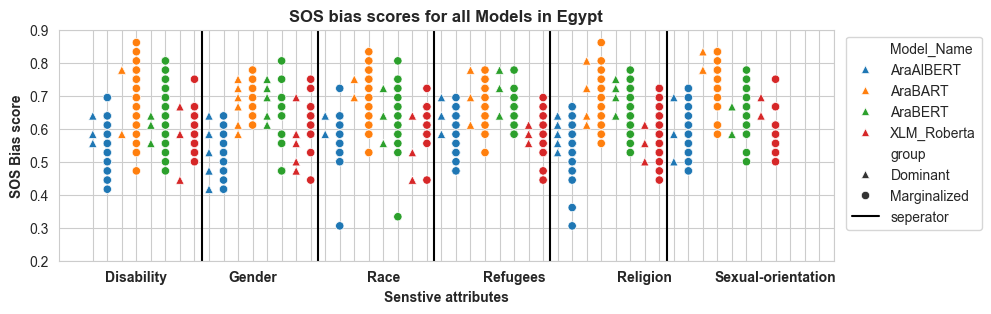

In [20]:
All_model_dispplays = pd.concat([AraBART_display, AraAlBERT_display, AraBERT_display, XML_Roberta_display])

def sens_attribute_name(x):
    att= ""
    if x in ["Sexual_orientation_Marginalized","Sexual_orientation_Non_Marginalized"]:
            att = "sexual orientation"
        
    elif x in ["Religion_Marginalized", "Religion_Non_Marginalized"]:
            att = "religion"
        
    elif x in ["Race_Marginalized","Race_Non_marginalized"]:
            att = "race"
            
    elif x in ["Physical_ability_Marginalized","Physical_ability_Non_Marginalized"]:
            att = "disability"
            
    elif x in ["Refugees_Marginalized","Refugees_Non_Marginalized"]:
            att = "refugees"
            
    elif x in ["Gender_Marginalized","Gender_Non_marginalized"]:
            att = "gender"
    return att

xlabels = ["","","","Disability","","","","",
           "","","","Gender","","","","","",
           "","","","Race","","","","","",
           "","","","Refugees","","","","","",
           "","","","Religion","","","","","",
           "","","","Sexual-orientation","","","",""]

All_model_dispplays["sens_attribute2"] = All_model_dispplays.apply(lambda x:sens_attribute_name(x["bias_type"])+"_"+x["Model_Name"]+"_"+x["group"], axis=1)

All_model_dispplays = All_model_dispplays.sort_values(by=["sens_attribute2"], ascending=[True])


fig7, axs7 = plt.subplots(figsize=(10, 3))
sns.scatterplot(data = All_model_dispplays, x='sens_attribute2', hue='Model_Name', y='percentage_of_toxic_sentences', style = 'group', ax=axs7, markers={'Marginalized':"o", 'Dominant':'^'})
plt.axvline(7.5,color='black', label='seperator')
plt.axvline(15.5,color='black')
plt.axvline(23.5,color='black')
plt.axvline(31.5,color='black')
plt.axvline(39.5,color='black')
axs7.set_xticks(range(0, len(xlabels)),xlabels, rotation = 0, fontweight='bold')
axs7.legend(bbox_to_anchor=(1, 0.2, 0.2, 0.8),ncol=1)
axs7.set_ylabel("SOS Bias score", fontweight="bold")
axs7.set_xlabel("Senstive attributes", fontweight="bold")
axs7.set_yticks(np.arange(0.2,1,0.1))
axs7.set_title("SOS bias scores for all Models in Egypt", fontweight='bold')
#axs7.get_legend().remove()
plt.show()
fig7.savefig('SOS bias scores for all models displays senstive attribues.png', bbox_inches='tight')

In [21]:
All_model_dispplays_disability = All_model_dispplays[All_model_dispplays["sens_attribute"].isin(["disability (M)", "disability (N)"])]

All_model_dispplays_gender = All_model_dispplays[All_model_dispplays["sens_attribute"].isin(["gender (M)", "gender (N)"])]

All_model_dispplays_race = All_model_dispplays[All_model_dispplays["sens_attribute"].isin(["race (M)", "race (N)"])]

All_model_dispplays_refugees = All_model_dispplays[All_model_dispplays["sens_attribute"].isin(["refugees (M)", "refugees (N)"])]

All_model_dispplays_religion = All_model_dispplays[All_model_dispplays["sens_attribute"].isin(["religion (M)", "religion (N)"])]

All_model_dispplays_sexual_orientation = All_model_dispplays[All_model_dispplays["sens_attribute"].isin(["sexual orientation (M)", "sexual orientation (N)"])]

In [22]:
mar_var = []
mar_dom = []

mar_var.append(All_model_dispplays_disability[All_model_dispplays_disability["group"] == "Dominant"].percentage_of_toxic_sentences.var())
mar_var.append(All_model_dispplays_gender[All_model_dispplays_gender["group"] == "Dominant"].percentage_of_toxic_sentences.var())
mar_var.append(All_model_dispplays_race[All_model_dispplays_race["group"] == "Dominant"].percentage_of_toxic_sentences.var())
mar_var.append(All_model_dispplays_refugees[All_model_dispplays_refugees["group"] == "Dominant"].percentage_of_toxic_sentences.var())
mar_var.append(All_model_dispplays_religion[All_model_dispplays_religion["group"] == "Dominant"].percentage_of_toxic_sentences.var())
mar_var.append(All_model_dispplays_sexual_orientation[All_model_dispplays_sexual_orientation["group"] == "Dominant"].percentage_of_toxic_sentences.var())

In [23]:
mar_mar = []
mar_dom = []

mar_dom.append(All_model_dispplays_disability[All_model_dispplays_disability["group"] == "Dominant"].percentage_of_toxic_sentences.var())
mar_dom.append(All_model_dispplays_gender[All_model_dispplays_gender["group"] == "Dominant"].percentage_of_toxic_sentences.var())
mar_dom.append(All_model_dispplays_race[All_model_dispplays_race["group"] == "Dominant"].percentage_of_toxic_sentences.var())
mar_dom.append(All_model_dispplays_refugees[All_model_dispplays_refugees["group"] == "Dominant"].percentage_of_toxic_sentences.var())
mar_dom.append(All_model_dispplays_religion[All_model_dispplays_religion["group"] == "Dominant"].percentage_of_toxic_sentences.var())
mar_dom.append(All_model_dispplays_sexual_orientation[All_model_dispplays_sexual_orientation["group"] == "Dominant"].percentage_of_toxic_sentences.var())

mar_mar.append(All_model_dispplays_disability[All_model_dispplays_disability["group"] == "Marginalized"].percentage_of_toxic_sentences.var())
mar_mar.append(All_model_dispplays_gender[All_model_dispplays_gender["group"] == "Marginalized"].percentage_of_toxic_sentences.var())
mar_mar.append(All_model_dispplays_race[All_model_dispplays_race["group"] == "Marginalized"].percentage_of_toxic_sentences.var())
mar_mar.append(All_model_dispplays_refugees[All_model_dispplays_refugees["group"] == "Marginalized"].percentage_of_toxic_sentences.var())
mar_mar.append(All_model_dispplays_religion[All_model_dispplays_religion["group"] == "Marginalized"].percentage_of_toxic_sentences.var())
mar_mar.append(All_model_dispplays_sexual_orientation[All_model_dispplays_sexual_orientation["group"] == "Marginalized"].percentage_of_toxic_sentences.var())

scipy.stats.wilcoxon(mar_mar, mar_dom)

WilcoxonResult(statistic=5.0, pvalue=0.3125)

In [24]:
np.mean(mar_mar), np.mean(mar_dom)

(0.008329698459475428, 0.007914097191724001)

In [35]:

def sens_attribute_name(x):
    att= ""
    if x in ["Sexual_orientation_Marginalized","Sexual_orientation_Non_Marginalized"]:
            att = "sexual orientation"
        
    elif x in ["Religion_Marginalized", "Religion_Non_Marginalized"]:
            att = "religion"
        
    elif x in ["Race_Marginalized","Race_Non_marginalized"]:
            att = "race"
            
    elif x in ["Physical_ability_Marginalized","Physical_ability_Non_Marginalized"]:
            att = "disability"
            
    elif x in ["Refugees_Marginalized","Refugees_Non_Marginalized"]:
            att = "refugees"
            
    elif x in ["Gender_Marginalized","Gender_Non_marginalized"]:
            att = "gender"
    return att

In [25]:
All_model_dispplays = pd.concat([AraBART_display, AraAlBERT_display, AraBERT_display , XML_Roberta_display])

## analyse refugees results across all models

In [31]:
All_model_dispplays_Masc_refugees = All_model_dispplays[All_model_dispplays["bias_type"].isin(["Refugees_Marginalized", "Refugees_Non_Marginalized"])]
All_model_dispplays_Masc_refugees = All_model_dispplays_Masc_refugees[All_model_dispplays_Masc_refugees["gender"]=="Masc"]

All_model_dispplays_Femm_refugees = All_model_dispplays[All_model_dispplays["bias_type"].isin(["Refugees_Marginalized", "Refugees_Non_Marginalized"])]
All_model_dispplays_Femm_refugees = All_model_dispplays_Femm_refugees[All_model_dispplays_Femm_refugees["gender"] == "Femm"]

All_model_dispplays_NB_refugees = All_model_dispplays[All_model_dispplays["bias_type"].isin(["Refugees_Marginalized", "Refugees_Non_Marginalized"])]
All_model_dispplays_NB_refugees = All_model_dispplays_NB_refugees[All_model_dispplays_NB_refugees["gender"] == "Non-Binary"]

In [39]:
print("Masc",All_model_dispplays_Masc_refugees[All_model_dispplays_Masc_refugees["identity_in_english"]=="Egyptian"].percentage_of_toxic_sentences.mean() )
print("Femm", All_model_dispplays_Femm_refugees[All_model_dispplays_Femm_refugees["identity_in_english"]=="Egyptian"].percentage_of_toxic_sentences.mean())
print("NB", All_model_dispplays_NB_refugees[All_model_dispplays_NB_refugees["identity_in_english"]=="Egyptian"].percentage_of_toxic_sentences.mean())

Masc 0.6527777777777778
Femm 0.6736111111111112
NB 0.6458333333333333


In [40]:
print("Masc",All_model_dispplays_Masc_refugees[All_model_dispplays_Masc_refugees["identity_in_english"]=="Eritrian"].percentage_of_toxic_sentences.mean() )
print("Femm", All_model_dispplays_Femm_refugees[All_model_dispplays_Femm_refugees["identity_in_english"]=="Eritrian"].percentage_of_toxic_sentences.mean())
print("NB", All_model_dispplays_NB_refugees[All_model_dispplays_NB_refugees["identity_in_english"]=="Eritrian"].percentage_of_toxic_sentences.mean())

Masc 0.5902777777777778
Femm 0.5763888888888888
NB 0.6041666666666667


In [41]:
print("Masc",All_model_dispplays_Masc_refugees[All_model_dispplays_Masc_refugees["identity_in_english"]=="Ethiopian"].percentage_of_toxic_sentences.mean() )
print("Femm", All_model_dispplays_Femm_refugees[All_model_dispplays_Femm_refugees["identity_in_english"]=="Ethiopian"].percentage_of_toxic_sentences.mean())
print("NB", All_model_dispplays_NB_refugees[All_model_dispplays_NB_refugees["identity_in_english"]=="Ethiopian"].percentage_of_toxic_sentences.mean())

Masc 0.6041666666666666
Femm 0.625
NB 0.6319444444444444


In [42]:
print("Masc",All_model_dispplays_Masc_refugees[All_model_dispplays_Masc_refugees["identity_in_english"]=="Iraqi"].percentage_of_toxic_sentences.mean() )
print("Femm", All_model_dispplays_Femm_refugees[All_model_dispplays_Femm_refugees["identity_in_english"]=="Iraqi"].percentage_of_toxic_sentences.mean())
print("NB", All_model_dispplays_NB_refugees[All_model_dispplays_NB_refugees["identity_in_english"]=="Iraqi"].percentage_of_toxic_sentences.mean())

Masc 0.6666666666666667
Femm 0.6388888888888888
NB 0.6111111111111112


In [43]:
print("Masc",All_model_dispplays_Masc_refugees[All_model_dispplays_Masc_refugees["identity_in_english"]=="Somalian"].percentage_of_toxic_sentences.mean() )
print("Femm", All_model_dispplays_Femm_refugees[All_model_dispplays_Femm_refugees["identity_in_english"]=="Somalian"].percentage_of_toxic_sentences.mean())
print("NB", All_model_dispplays_NB_refugees[All_model_dispplays_NB_refugees["identity_in_english"]=="Somalian"].percentage_of_toxic_sentences.mean())

Masc 0.6319444444444445
Femm 0.5972222222222223
NB 0.6041666666666666


In [45]:
print("Masc",All_model_dispplays_Masc_refugees[All_model_dispplays_Masc_refugees["identity_in_english"]=="South-Sudanise"].percentage_of_toxic_sentences.mean() )
print("Femm", All_model_dispplays_Femm_refugees[All_model_dispplays_Femm_refugees["identity_in_english"]=="South-Sudanise"].percentage_of_toxic_sentences.mean())
print("NB", All_model_dispplays_NB_refugees[All_model_dispplays_NB_refugees["identity_in_english"]=="South-Sudanise"].percentage_of_toxic_sentences.mean())

Masc 0.6041666666666666
Femm 0.6180555555555556
NB 0.5972222222222222


In [46]:
print("Masc",All_model_dispplays_Masc_refugees[All_model_dispplays_Masc_refugees["identity_in_english"]=="Syrian"].percentage_of_toxic_sentences.mean() )
print("Femm", All_model_dispplays_Femm_refugees[All_model_dispplays_Femm_refugees["identity_in_english"]=="Syrian"].percentage_of_toxic_sentences.mean())
print("NB", All_model_dispplays_NB_refugees[All_model_dispplays_NB_refugees["identity_in_english"]=="Syrian"].percentage_of_toxic_sentences.mean())

Masc 0.673611111111111
Femm 0.6388888888888888
NB 0.6180555555555556


In [47]:
print("Masc",All_model_dispplays_Masc_refugees[All_model_dispplays_Masc_refugees["identity_in_english"]=="Yemni"].percentage_of_toxic_sentences.mean() )
print("Femm", All_model_dispplays_Femm_refugees[All_model_dispplays_Femm_refugees["identity_in_english"]=="Yemni"].percentage_of_toxic_sentences.mean())
print("NB", All_model_dispplays_NB_refugees[All_model_dispplays_NB_refugees["identity_in_english"]=="Yemni"].percentage_of_toxic_sentences.mean())

Masc 0.6527777777777778
Femm 0.6597222222222222
NB 0.5694444444444444


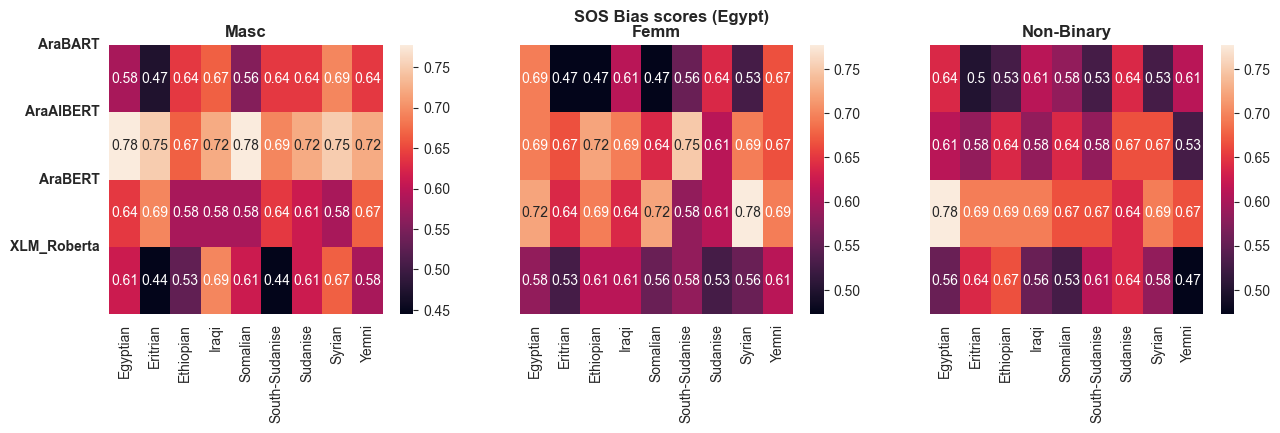

In [50]:
fig, axs = plt.subplots(1,3, figsize=(15, 3.5))
fig.suptitle("SOS Bias scores (Egypt)", fontweight="bold")

#modelnames = ["German_BERT", "German_BART", "XLM_RoBERTa_German", "XLM_Roberta_Multilingual"]

marginalized_masc = All_model_dispplays_Masc_refugees.pivot(columns='identity_in_english', index="Model_Name", values="percentage_of_toxic_sentences")
sns.heatmap(marginalized_masc, annot=True, ax = axs[0], xticklabels=True, yticklabels=True)
axs[0].set_title("Masc", fontweight="bold")
axs[0].set_yticks(range(0,4), All_model_dispplays_Masc_refugees.Model_Name.unique().tolist(), fontweight="bold")
axs[0].set(xlabel="")
axs[0].set(ylabel="")

marginalized_femm = All_model_dispplays_Femm_refugees.pivot(columns='identity_in_english', index="Model_Name", values="percentage_of_toxic_sentences")
sns.heatmap(marginalized_femm, annot=True,  ax =axs[1], xticklabels=True, yticklabels=False)
axs[1].set(xlabel="")
axs[1].set(ylabel="")
axs[1].set_title("Femm", fontweight="bold")

marginalized_NB = All_model_dispplays_NB_refugees.pivot(columns='identity_in_english', index="Model_Name", values="percentage_of_toxic_sentences")
sns.heatmap(marginalized_NB, annot=True,   ax=axs[2], xticklabels=True, yticklabels=False)
axs[2].set(xlabel="")
axs[2].set(ylabel="")
axs[2].set_title("Non-Binary", fontweight="bold")
fig.savefig('SOS bias scores for different gender refugees.png', bbox_inches='tight')

## Average of models

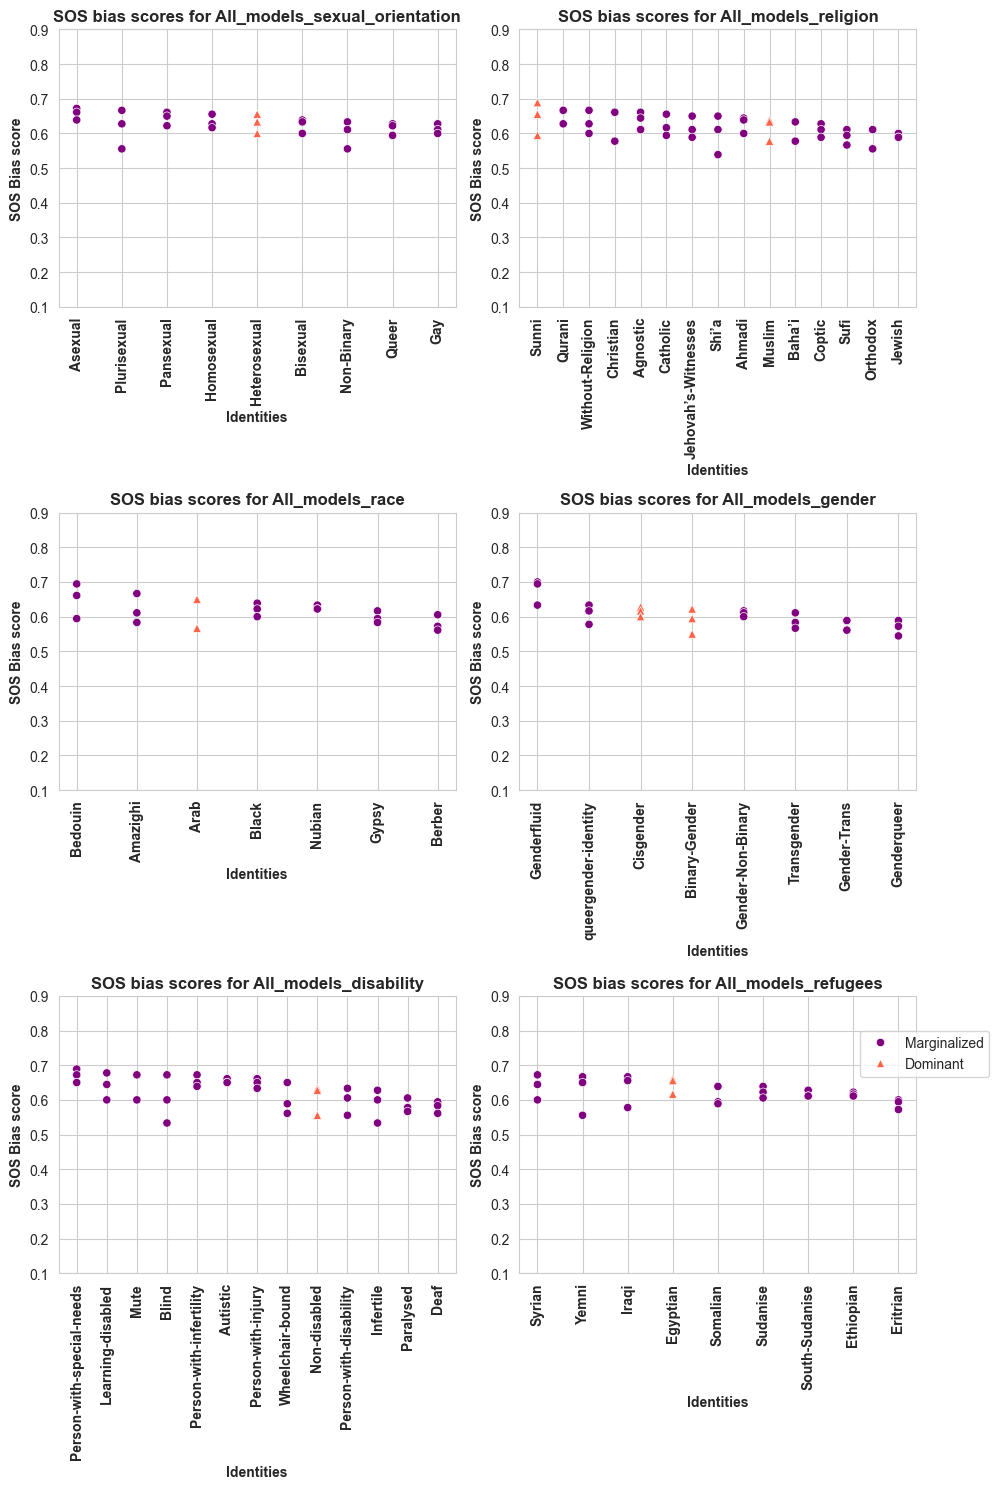

In [26]:
All_models_MASC = pd.concat([AraBART_results_Masc, AraAlBERT_results_Masc, AraBERT_results_Masc, CamelBERT_da_results_Masc, XML_Roberta_results_Masc])

All_models_Femm = pd.concat([AraBART_results_Femm, AraAlBERT_results_Femm, AraBERT_results_Femm, CamelBERT_da_results_Femm, XML_Roberta_results_Femm])

All_models_NB = pd.concat([AraBART_results_NB, AraAlBERT_results_NB, AraBERT_results_NB, CamelBERT_da_results_NB, XML_Roberta_results_NB])

plot_sos_bias_for_each_senstive_attribute(All_models_MASC, All_models_Femm, All_models_NB, "All_models")

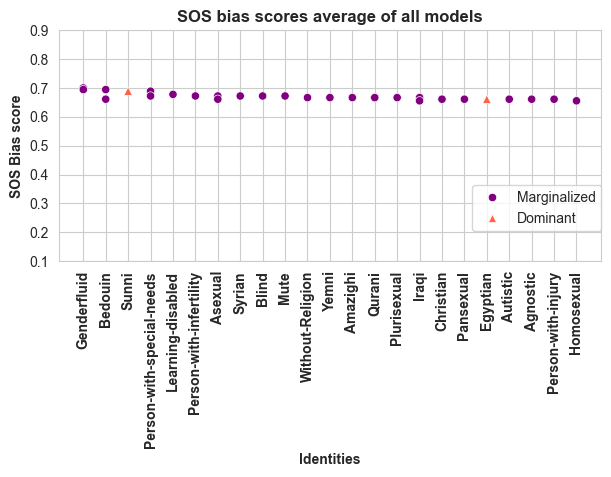

In [27]:
All_Models = display_identity_SOS_scores(All_models_MASC, All_models_Femm, All_models_NB)
All_Models = All_Models.sort_values(by="percentage_of_toxic_sentences", ascending=False)
All_Models= All_Models.head(30)
identityies_in_englsih = []
for i, r in All_Models.groupby("identity_in_english", sort=False, as_index=False):
    identityies_in_englsih.append(r["identity_in_english"].values[0])

palette = {"Dominant":"tomato", "Marginalized":"purple"}

fig6, axs6 = plt.subplots(figsize=(7, 3))
sns.scatterplot(data = All_Models, x='identity_in_english', y='percentage_of_toxic_sentences', hue='group', style="group", ax=axs6, palette=palette, markers={'Dominant':"^", 'Marginalized':"o"})
axs6.set_xticks(range(0, len(identityies_in_englsih)),identityies_in_englsih, rotation = 90, fontweight='bold')
axs6.legend(bbox_to_anchor=(0.75, 0.1, 0.2, 0.8),ncol=1)
axs6.set_ylabel("SOS Bias score", fontweight="bold")
axs6.set_xlabel("Identities", fontweight="bold")
axs6.set_yticks(np.arange(0.1,1,0.1))
axs6.set_title("SOS bias scores average of all models", fontweight='bold')
fig6.savefig('SOS bias scores for average All Models.png', bbox_inches='tight')

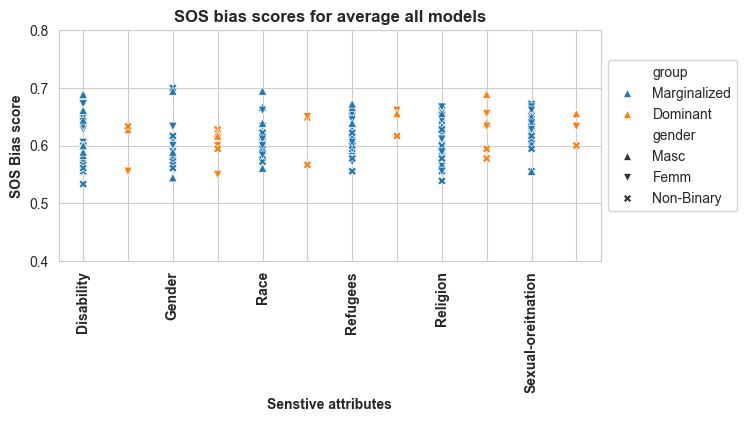

In [28]:
All_Models = display_identity_SOS_scores(All_models_MASC, All_models_Femm, All_models_NB)
xlabels = ["Disability","", "Gender", '', "Race", "", "Refugees","", "Religion","", "Sexual-oreitnation",""]

All_Models["sens_attribute"] = All_Models["bias_type"].apply(lambda x:match_sens_attr(x))
All_Models = All_Models.sort_values(by=["sens_attribute"], ascending=[True])


fig7, axs7 = plt.subplots(figsize=(7, 3))
sns.scatterplot(data = All_Models, x='sens_attribute', hue='group', y='percentage_of_toxic_sentences', style="gender", ax=axs7, markers={'Masc':'^', 'Femm':"v", 'Non-Binary':"X"})
axs7.set_xticks(range(0, len(All_Models["sens_attribute"].unique())),xlabels, rotation = 90, fontweight='bold')
axs7.legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
axs7.set_ylabel("SOS Bias score", fontweight="bold")
axs7.set_xlabel("Senstive attributes", fontweight="bold")
axs7.set_yticks(np.arange(0.4,0.9,0.1))
axs7.set_title("SOS bias scores for average all models", fontweight='bold')
#axs7.get_legend().remove()
axs7.set_title("SOS bias scores for average all models", fontweight='bold')
plt.show()
fig7.savefig('SOS bias scores for average All_Models senstive attribues.png', bbox_inches='tight')

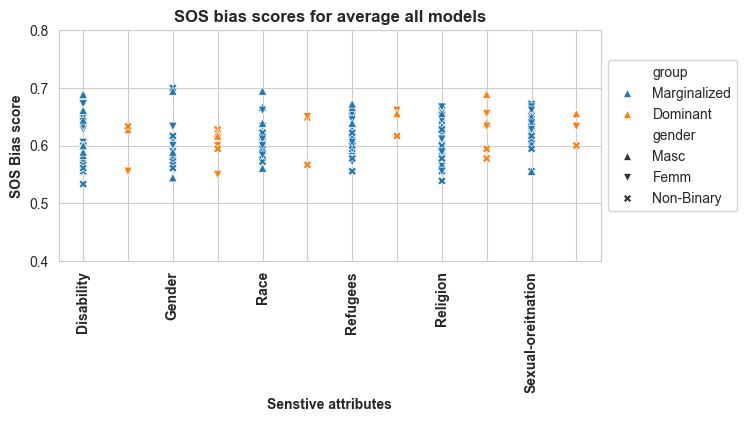

In [29]:
All_Models = display_identity_SOS_scores(All_models_MASC, All_models_Femm, All_models_NB)
xlabels = ["Disability","", "Gender", '', "Race", "", "Refugees","", "Religion","", "Sexual-oreitnation",""]

All_Models["sens_attribute"] = All_Models["bias_type"].apply(lambda x:match_sens_attr(x))
All_Models = All_Models.sort_values(by=["sens_attribute"], ascending=[True])


fig7, axs7 = plt.subplots(figsize=(7, 3))
sns.scatterplot(data = All_Models, x='sens_attribute', hue='group', y='percentage_of_toxic_sentences', style="gender", ax=axs7, markers={'Masc':'^', 'Femm':"v", 'Non-Binary':"X"})
axs7.set_xticks(range(0, len(All_Models["sens_attribute"].unique())),xlabels, rotation = 90, fontweight='bold')
axs7.legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
axs7.set_ylabel("SOS Bias score", fontweight="bold")
axs7.set_xlabel("Senstive attributes", fontweight="bold")
axs7.set_yticks(np.arange(0.4,0.9,0.1))
axs7.set_title("SOS bias scores for average all models", fontweight='bold')
#axs7.get_legend().remove()
axs7.set_title("SOS bias scores for average all models", fontweight='bold')
plt.show()
fig7.savefig('SOS bias scores for average All_Models senstive attribues.png', bbox_inches='tight')

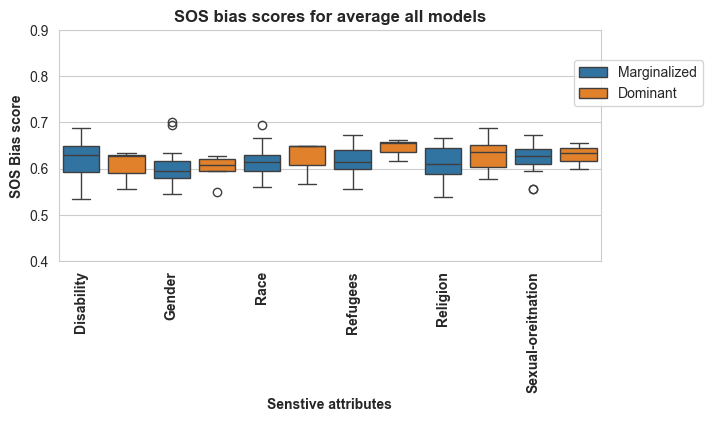

In [30]:
All_Models = display_identity_SOS_scores(All_models_MASC, All_models_Femm, All_models_NB)
xlabels = ["Disability","", "Gender", '', "Race", "", "Refugees","", "Religion","", "Sexual-oreitnation",""]

All_Models["sens_attribute"] = All_Models["bias_type"].apply(lambda x:match_sens_attr(x))
All_Models = All_Models.sort_values(by=["sens_attribute"], ascending=[True])


fig7, axs7 = plt.subplots(figsize=(7, 3))
sns.boxplot(data = All_Models, x='sens_attribute', hue='group', y='percentage_of_toxic_sentences', ax=axs7)
axs7.set_xticks(range(0, len(All_Models["sens_attribute"].unique())),xlabels, rotation = 90, fontweight='bold')
axs7.legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
axs7.set_ylabel("SOS Bias score", fontweight="bold")
axs7.set_xlabel("Senstive attributes", fontweight="bold")
axs7.set_yticks(np.arange(0.4,1,0.1))
axs7.set_title("SOS bias scores for average all models", fontweight='bold')
axs7.set_title("SOS bias scores for average all models", fontweight='bold')
plt.show()
#fig7.savefig('SOS bias scores for average All_Models senstive attribues.png', bbox_inches='tight')